In [1]:
import numpy as np
from matplotlib import pyplot as plt
import h5py as h5
import glob
import statsmodels.api as sm
import pickle as pkl
import scipy
from scipy.ndimage.morphology import binary_dilation
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from scipy.interpolate import splprep, splev
from matplotlib.patches import Rectangle

In [2]:
start_iter = 10
end_iter = 10000
num_cells = 1000
num_vir = 10000
state = 'Uniform'
fl0, fl1 = '/media/data2/greyson/IBMViral/20200218/', '_{:05d}_{}_{}.svg'.format(num_vir, num_cells, state.lower())

In [16]:
f = h5.File('/media/fastdata/greyson/IBMViral/20200218/iterative_uniform/01kcells_10000v/01kcells_{0:05d}v_{1}_withrep_dtype_set_npdouble.hdf5'.format(num_vir, state.lower()), 'r')
f_nat = h5.File('/media/fastdata/greyson/IBMViral/20210715/01kcells_10000v_natural_withrep_npdouble_rerun20210715.hdf5', 'r')



In [4]:
def fib_interp(exp):
    phi_fib = (1 + np.sqrt(5)) / 2
    return (np.power(phi_fib, exp) - np.cos(np.pi * exp) * np.power(phi_fib, -1*exp)) / np.sqrt(5)

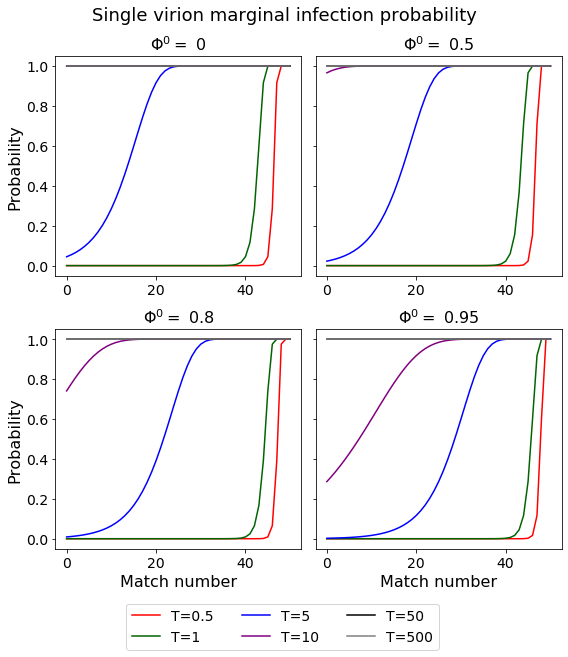

In [5]:
pr_ff = [0, 0.5, 0.8, 0.95]
c_list = ['red', 'darkgreen', 'blue', 'purple', 'black', 'gray']
plt.close()
fig, axs = plt.subplots(2,2, sharey=True, figsize=(8,8))
for i in range(len(pr_ff)):
    for t_to_plot in zip([0.5, 1, 5, 10, 50, 500], c_list):
        axs[int(i/2)][i % 2].plot(range(51), [(1 - np.power(1 - np.exp(-(50-_) / t_to_plot[0]) * 
                                                             (1 - pr_ff[i]), 1000)) 
                  for _ in range(51)], c=t_to_plot[1], label='T={}'.format(t_to_plot[0]))
    axs[int(i/2)][i % 2].set_title(r'$\Phi^{0} = $' + ' {}'.format(pr_ff[i]), size=16)
    if i % 2 == 0:
        axs[int(i/2)][i % 2].set_ylabel('Probability', size=16)
    if i > 1:
        axs[int(i/2)][i % 2].set_xlabel('Match number', size=16)
    axs[int(i/2)][i % 2].tick_params(axis='both', labelsize=14)
        
plt.tight_layout()
plt.suptitle('Single virion marginal infection probability', y=1.03, size=18)
plt.legend(bbox_to_anchor=(0.5, -0.25), ncol=3, borderaxespad=0, fontsize=14)
plt.show()
plt.close()

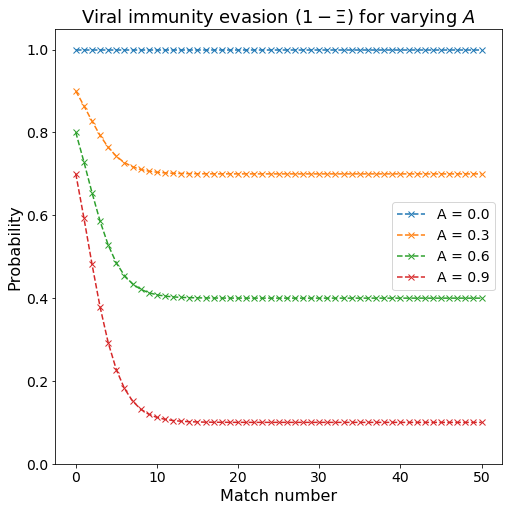

In [6]:
M = 50
v = 6
plt.close()
plt.figure(figsize=(8, 8))
for i in range(0, 11, 3):
    plt.plot(1.0 - i/(10.0 + np.exp(-(np.arange(M+1)-v)/2)), 'x--', label='A = {:3.1f}'.format(i / 10.))
plt.legend(fontsize=14)
plt.title(u'Viral immunity evasion ($1 - \Xi$) for varying $A$', size=18)
plt.ylabel('Probability', size=16)
plt.xlabel('Match number', size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.ylim([0.0, 1.05])
plt.show()
plt.close()


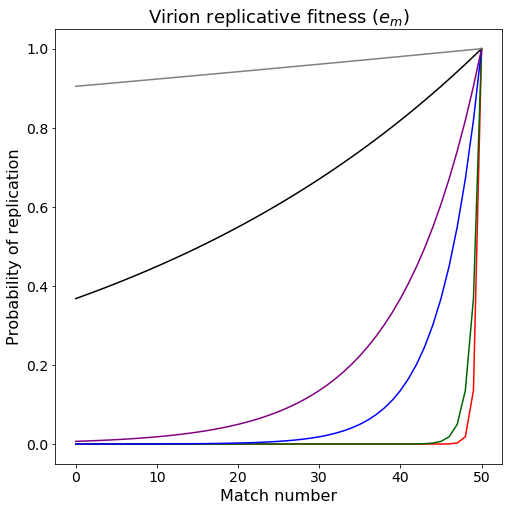

In [7]:
plt.close()
plt.figure(figsize=(8,8))
c_list = c_list = ['red', 'darkgreen', 'blue', 'purple', 'black', 'gray']
for ind, ttp_em in enumerate([0.5, 1, 5, 10, 50, 500]):
    plt.plot(range(51), [np.exp(-(50 - _) / (ttp_em)) for _ in range(51)], c=c_list[ind], 
             label='T={}'.format(ttp_em))
# plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, fontsize=12)
plt.title('Virion replicative fitness (' + r'$e_{m}$' + ')', size=18)
plt.xlabel('Match number', size=16)
plt.ylabel('Probability of replication', size=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.close()

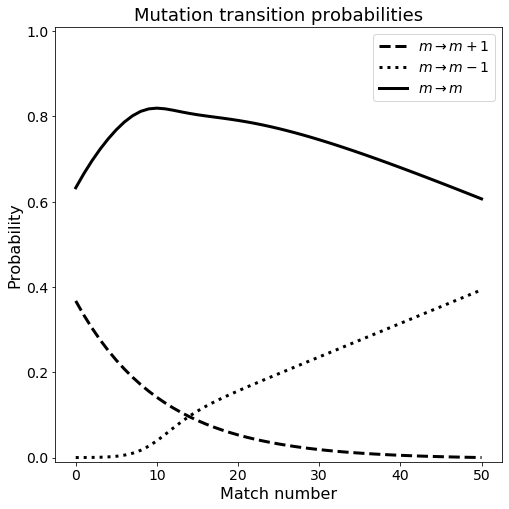

In [8]:
M=50
w=0.7867
mut_mat = np.zeros((M+1,M+1))
for i in range(0,M):
    # one fewer match
    mut_mat[i][i+1] = (w/100.0)*((i+1)*1.0/(1.0 + np.exp(-(1.0*(i+1)-10)/2)))
    # one more match
    mut_mat[i+1][i] = (w/235.45)*(np.exp(4.709*(1.0-1.0*i/50.0))-1)
    # same number of matches
for i in range(1,M):
    mut_mat[i][i] = 1.0 - mut_mat[i+1][i] - mut_mat[i-1][i]
mut_mat[0][0] = 1.0 - mut_mat[1][0]
mut_mat[M][M] = 1.0 - mut_mat[M-1][M]
mut_mat[50]

pmdown = np.zeros(51)
pmdown[1:] = [(w/100.0)*((i)*1.0/(1.0 + np.exp(-(1.0*(i)-10)/2))) for i in range(1,51)]
pmup = np.zeros(51)
pmup[:50] = [(w/235.45)*(np.exp(4.709*(1.0-i/50.0))-1) for i in range(50)]
pmsame = 1 - pmup - pmdown
plt.close()
plt.figure(figsize=(8, 8))
plt.plot(pmup, 'k--', lw=3, label=r'$m \rightarrow m+1$')
plt.plot(pmdown, 'k:', lw=3, label=r'$m \rightarrow m-1$')
plt.plot(pmsame, 'k-', lw=3, label=r'$m \rightarrow m$')
# plt.plot(range(1,51), [mut_mat[_][_+1] for _ in range(50)], 'x', label='mut m-1')
# plt.plot(range(50),[mut_mat[_+1][_] for _ in range(50)], 'x', label='mut m+1')
plt.legend(fontsize=14)
plt.ylim([-0.01, 1.01])
plt.ylabel('Probability', size=16)
plt.xlabel('Match number', size=16)
plt.title('Mutation transition probabilities', size=18)
# plt.xticklabels()
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()
plt.close()

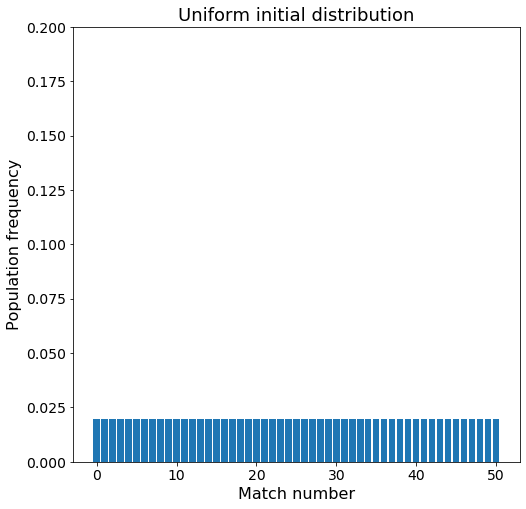

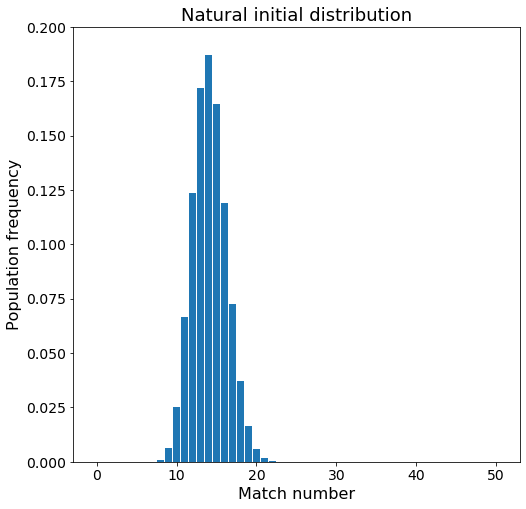

In [9]:
plt.close()
plt.figure(figsize=(8,8))
plt.bar(np.arange(51), height=np.ones(51)/51)
plt.title('Uniform initial distribution', size=18)
plt.xlabel('Match number', size=16)
plt.ylabel('Population frequency', size=16)
plt.ylim([0,0.2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.close()
plt.close()
plt.figure(figsize=(8,8))
plt.bar(np.arange(51), height=f_nat['prob_dists'][-1,-1,0])
plt.title('Natural initial distribution', size=18)
plt.xlabel('Match number', size=16)
plt.ylabel('Population frequency', size=16)
plt.ylim([0,0.2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()
plt.close()

In [10]:
temp_list = np.array(sorted(list(set([_.split('/')[-1].split('_')[0] for _ in sorted(glob.glob('/media/data2/greyson/IBMViral/20200218/iterative_uniform/01kcells_10000v/*.p'))]))))
temp_list = sorted(['0' + _ if (len(_) == 6) else _ for _ in temp_list])
imm_list = np.array(sorted(list(set([_.split('/')[-1].split('_')[1][:-2] for _ in sorted(glob.glob('/media/data2/greyson/IBMViral/20200218/iterative_uniform/01kcells_10000v/*.p'))]))))
from itertools import product
temp_vals = np.logspace(np.log(0.1), np.log(300), num=50, base=np.e)
fac = temp_vals[-1] / temp_vals[-2]
temp_vals = np.array(list(temp_vals) + [temp_vals[-1] * (fac ** _) for _ in range(1,10)])
imm_vals = np.linspace(0, 1, num=50)


In [9]:
# modified 2021/04/02 to switch & to | (and to or)
# just pop size
# last_loc_with = [[np.where((np.abs(f['pop_size'][i,j] - f['pop_size'][i,j,-1]) / (f['pop_size'][i,j,-1] + 1e-10) > 1e-03) 
#                              ) for j in range(ord_param.shape[1])] for i in range(ord_param.shape[0])]
# last_loc_with_nat = [[np.where((np.abs(f_nat['pop_size'][i,j] - f_nat['pop_size'][i,j,-1]) / (f_nat['pop_size'][i,j,-1] + 1e-10) > 1e-03))
#                       for j in range(ord_param.shape[1])] for i in range(ord_param.shape[0])]

# relative error convergence threshold of 1e-3
# last_loc_with = [[np.where((np.abs(f['pop_size'][i,j] - f['pop_size'][i,j,-1]) / (
#     f['pop_size'][i,j,-1] + 1e-10) > 1e-03) | 
#                              (np.abs(ord_param_with_dyn[i,j] - ord_param_with_dyn[i,j,-1]) / (
#                                  ord_param_with_dyn[i,j,-1] + 1e-10) > 1e-03)
#                           ) for j in range(ord_param.shape[1])] for i in range(ord_param.shape[0])]
# last_loc_with_nat = [[np.where((np.abs(f_nat['pop_size'][i,j] - f_nat['pop_size'][i,j,-1]) / (
#     f_nat['pop_size'][i,j,-1] + 1e-10) > 1e-03) | 
#                              (np.abs(ord_param_with_dyn_nat[i,j] - ord_param_with_dyn_nat[i,j,-1]) / (
#                                  ord_param_with_dyn_nat[i,j,-1] + 1e-10) > 1e-03)
#                               ) for j in range(ord_param.shape[1])] for i in range(ord_param.shape[0])]

# calculation of where either pop size or ord param differ from
# steady-state values by more than 1e-4
# 0-1 normalized pop size and ord-param, absolute error of 1e-4
last_loc_with = [[np.where((np.abs(f['pop_size'][i,j] - f['pop_size'][i,j,-1])/20000  > 1e-04) | 
                             (np.abs(f['ord_param'][i,j] - f['ord_param'][i,j,-1])  > 1e-04)
                          ) for j in range(f['ord_param'].shape[1])] for i in range(f['ord_param'].shape[0])]
last_loc_with_nat = [[np.where((np.abs(f_nat['pop_size'][i,j] - f_nat['pop_size'][i,j,-1])/20000 > 1e-04) | 
                             (np.abs(f_nat['ord_param'][i,j] - f_nat['ord_param'][i,j,-1]) > 1e-04)
                              ) for j in range(f_nat['ord_param'].shape[1])] for i in range(f_nat['ord_param'].shape[0])]

    
# modified 2021/04/02 to cover edge case of convergence at iteration 0
# simulation has converged when env pop dips below 1e-8
# or when the rest of the simulation differs from steady-state value
# by less than 1e-4 in both ord param and env pop size

last_iter_with = np.ones((f['ord_param'].shape[0],f['ord_param'].shape[1]))
last_iter_with_nat = np.ones((f_nat['ord_param'].shape[0],f_nat['ord_param'].shape[1]))

for i in range(f['ord_param'].shape[0]):
    for j in range(f['ord_param'].shape[1]):
        if np.any(f['pop_size'][i,j] <= 1e-8):
            last_iter_with[i,j] = np.where(f['pop_size'][i,j] <= 1e-8)[0][0] - 1
        else:
            if last_loc_with[i][j][0].shape[0] > 0:
                last_iter_with[i,j] = last_loc_with[i][j][0][-1] + 1
            else:
                last_iter_with[i,j] = 0


for i in range(f_nat['ord_param'].shape[0]):
    for j in range(f_nat['ord_param'].shape[1]):
        if np.any(f_nat['pop_size'][i,j] <= 1e-8):
            last_iter_with_nat[i,j] = np.where(f_nat['pop_size'][i,j] <= 1e-8)[0][0] - 1
        else:
            if last_loc_with_nat[i][j][0].shape[0] > 0:
                last_iter_with_nat[i,j] = last_loc_with_nat[i][j][0][-1] + 1
            else:
                last_iter_with_nat[i,j] = 0

    

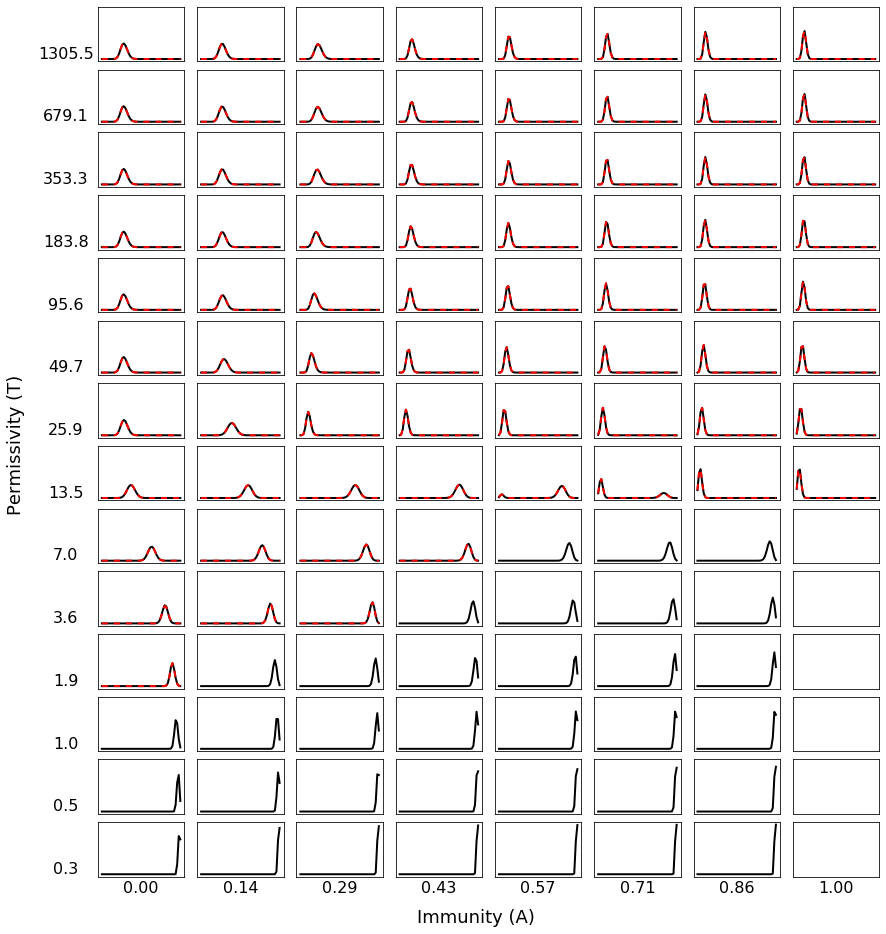

In [10]:
plt.close()
fig, axs = plt.subplots(int(len(temp_list) / 4), 8, sharex=True, sharey=True, figsize=(14,16),
                       gridspec_kw={'hspace': 0.15, 'wspace': 0.15})
scf = 4
for i in range(int(len(temp_list) / scf)):
    axs[i, 0].set_ylabel('{:.1f}'.format(temp_vals[len(temp_list) - 1 - scf*i]), 
                         rotation='horizontal', position=(0, 0), labelpad=32, size=16)
    for j in range(0, 8):
        if i == int(len(temp_list) / scf) - 1:
            axs[i, j].set_xlabel('{:.2f}'.format(imm_vals[7*j]), size=16)
        if np.all(f['pop_size'][len(temp_list) - 1 - scf*i, 7*j] > 1e-8):
            axs[i, j].plot(f['prob_dists'][len(temp_list) - 1 - scf*i, 7*j, -1], 'k-', lw=2)
        if np.all(f_nat['pop_size'][len(temp_list) - 1 - scf*i, 7*j] > 1e-8):
            axs[i, j].plot(f_nat['prob_dists'][len(temp_list) - 1 - scf*i, 7*j, -1], 'r--', lw=2, dashes=(3, 3))
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].set_xticklabels([])
        axs[i, j].set_yticklabels([])
plt.subplots_adjust(hspace=0.15)
fig.align_ylabels(axs[:, 0])
fig.text(0.5, 0.085, 'Immunity (A)', ha='center', size=18)
fig.text(0.035, 0.5, 'Permissivity (T)', va='center', rotation='vertical', size=18)
plt.show()
plt.close()

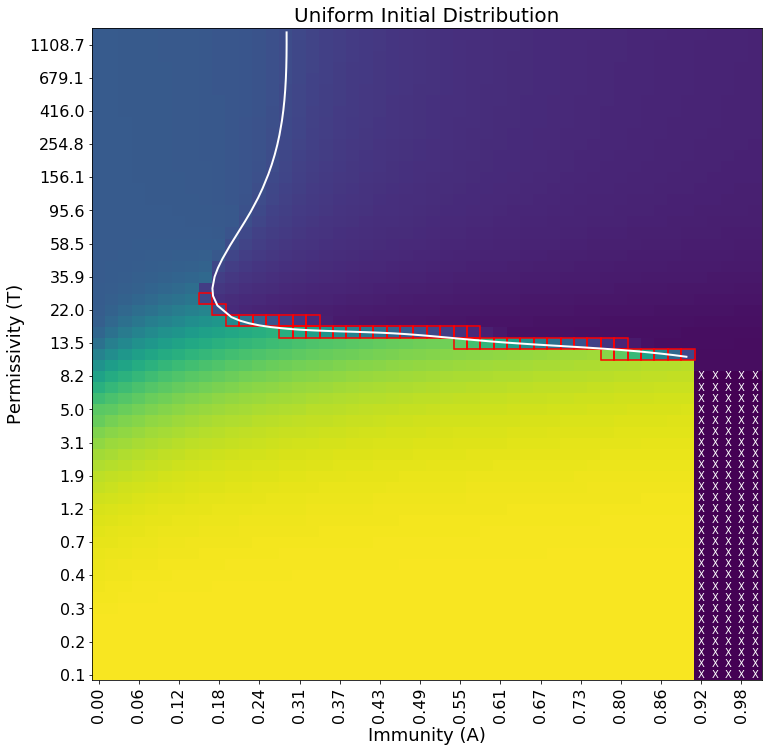

In [11]:
lb = 28
col_lb = 32
row_lb = 10
row_ub = -5
numpeaks_raw = [[scipy.signal.find_peaks(x, height=0.01)[0] for x in _] 
                for _ in f['prob_dists'][:,:,-1]]
numpeaks = np.array([ [x.shape[0] for x in _] for _ in numpeaks_raw])
twopeaks = np.where(numpeaks == 2)

col_maxdiffs = np.argmax(np.abs(
    f['ord_param'][col_lb:, 2:, -1] - f['ord_param'][col_lb:, :-2, -1]) / 2 / (imm_vals[1] - imm_vals[0])
                      , axis=1) + 1.5

row_maxdiffs = np.argmax(np.abs(
    f['ord_param'][lb + 2:, row_lb:row_ub, -1] - f['ord_param'][lb : -2, row_lb:row_ub, -1]) / 2 / np.array(
    [list(temp_vals[lb + 2:] - temp_vals[lb: - 2])] * len(range(row_lb,len(imm_vals) + row_ub))).T
                      , axis=0) + 1.5 + lb

colmax_diff = [np.argmax(np.abs(np.diff(f['ord_param'][_,:, -1]))) + 1 for _ in range(lb,59)]
max_diff = [np.argmax(np.abs(np.diff(f['ord_param'][lb:,_, -1]))) + 1 for _ in range(50)]

cs_x = list(col_maxdiffs)[::-1] + list(np.arange(row_lb, len(imm_vals) + row_ub) + 0.5)
cs_y = list(np.arange(col_lb, f['ord_param'].shape[0]) + 0.5)[::-1] + list(row_maxdiffs)
tck, u = splprep(np.array([cs_x, cs_y]), k=3, s=7)
out = splev(u,tck)

plt.close()
plt.figure(figsize=(12,12))
plt.pcolormesh(f['ord_param'][:,:,-1] * np.all(f['pop_size'][:,:] > 1e-8, axis=2), vmin=0, vmax=1, cmap='viridis')
plt.title('Uniform Initial Distribution', size=20)
plt.xticks(0.5 + 3*np.arange(len(imm_list[::3])), 
           ['{:.2f}'.format(_) for _ in imm_vals[::3]], size=16, rotation=90)
plt.yticks(0.5 + 3*np.arange(len(temp_list[::3])), 
           ['{:.1f}'.format(_) for _ in temp_vals[::3]], size=16)
plt.xlabel('Immunity (A)', size=18, y=0.9)
plt.ylabel('Permissivity (T)', size=18)
plt.plot(out[0], out[1], c='white', ls='-', lw=2)

for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if (numpeaks[y, x] == 2) and (x != 0):
            plt.gca().add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1.5))
            
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if np.any(f['pop_size'][y, x] < 1e-8):
            plt.text(x + 0.5, y + 0.5, 'X',
                     color='white',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
plt.show()
plt.close()

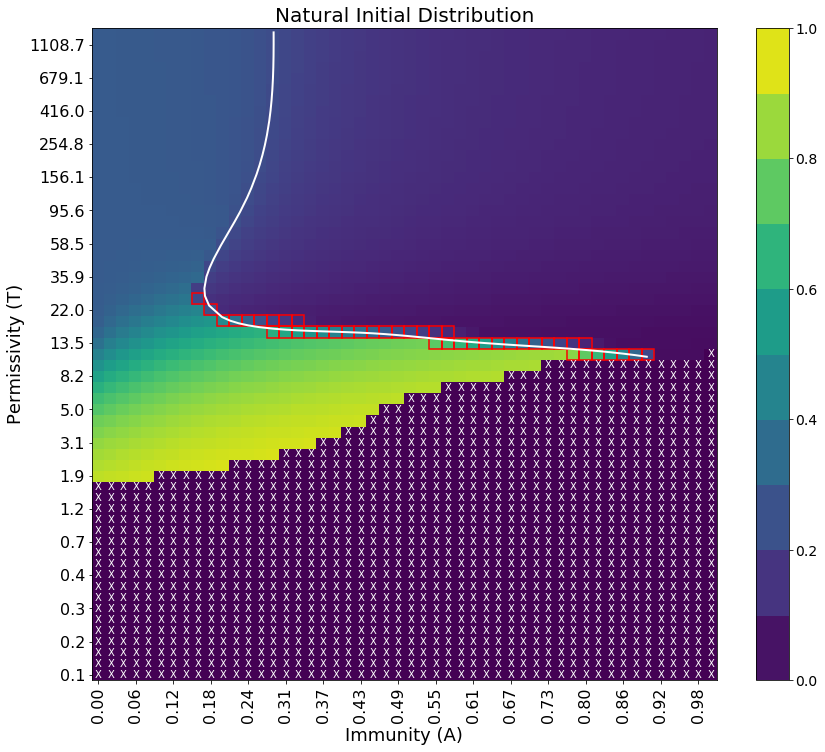

In [12]:
# from scipy.interpolate import splprep, splev
lb = 28
col_lb = 32
row_lb = 10
row_ub = -5
numpeaks_raw_nat = [[scipy.signal.find_peaks(x, height=0.01)[0] for x in _] 
                for _ in f_nat['prob_dists'][:,:,-1]]
numpeaks_nat = np.array([ [x.shape[0] for x in _] for _ in numpeaks_raw_nat])
twopeaks_nat = np.where(numpeaks_nat == 2)

col_maxdiffs_nat = np.argmax(np.abs(
    f_nat['ord_param'][col_lb:, 2:, -1] - f_nat['ord_param'][col_lb:, :-2, -1]) / 2 / (imm_vals[1] - imm_vals[0])
                      , axis=1) + 1.5

row_maxdiffs_nat = np.argmax(np.abs(
    f_nat['ord_param'][lb + 2:, row_lb:row_ub, -1] - f_nat['ord_param'][lb : -2, row_lb:row_ub, -1]) / 2 / np.array(
    [list(temp_vals[lb + 2:] - temp_vals[lb: - 2])] * len(range(row_lb,len(imm_vals) + row_ub))).T
                      , axis=0) + 1.5 + lb

cs_x_nat = list(col_maxdiffs_nat)[::-1] + list(np.arange(row_lb, len(imm_vals) + row_ub) + 0.5)
cs_y_nat = list(np.arange(col_lb, f_nat['ord_param'].shape[0]) + 0.5)[::-1] + list(row_maxdiffs_nat)
tck_nat, u_nat = splprep(np.array([cs_x_nat, cs_y_nat]), k=3, s=7)
out_nat = splev(u_nat,tck_nat)


# extinction boundary calculation for natural initial distribution
# adapted from
# https://stackoverflow.com/questions/51696326/extracting-boundary-of-a-numpy-array/51696521#51696521
# the last two lines of code below are adapted from the 4-connected boundary code
# and are subject to the CC BY-SA 4.0 license found at https://creativecommons.org/licenses/by-sa/4.0/
ex_mat = np.any(f_nat['pop_size'][...] <= 1e-8, axis=2)
ex_mat = ex_mat.astype(int)
kernel = np.ones((3,3), dtype=int)
nat_ex_bound = np.where(binary_dilation(ex_mat==0, kernel) & ex_mat)



plt.close()
plt.figure(figsize=(14,12))
plt.pcolormesh(f_nat['ord_param'][:,:,-1] * np.all(f_nat['pop_size'][:,:] > 1e-8, axis=2), vmin=0, vmax=1, cmap='viridis')
cbar = plt.colorbar(boundaries=np.asarray([0.1 * _ for _ in range(11)]))
cbar.ax.tick_params(labelsize=14)
plt.title('Natural Initial Distribution', size=20)
plt.xticks(0.5 + 3*np.arange(len(imm_list[::3])), 
           ['{:.2f}'.format(_) for _ in imm_vals[::3]], size=16, rotation=90)
plt.yticks(0.5 + 3*np.arange(len(temp_list[::3])), 
           ['{:.1f}'.format(_) for _ in temp_vals[::3]], size=16)
plt.xlabel('Immunity (A)', size=18, y=0.9)
plt.ylabel('Permissivity (T)', size=18)
plt.plot(out[0], out[1], c='white', ls='-', lw=2)

for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if (numpeaks_nat[y, x] == 2) and (x != 0):
            plt.gca().add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1.5))

            
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if np.any(f_nat['pop_size'][y, x] < 1e-8):
            plt.text(x + 0.5, y + 0.5, 'X',
                     color='white',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
plt.show()
plt.close()

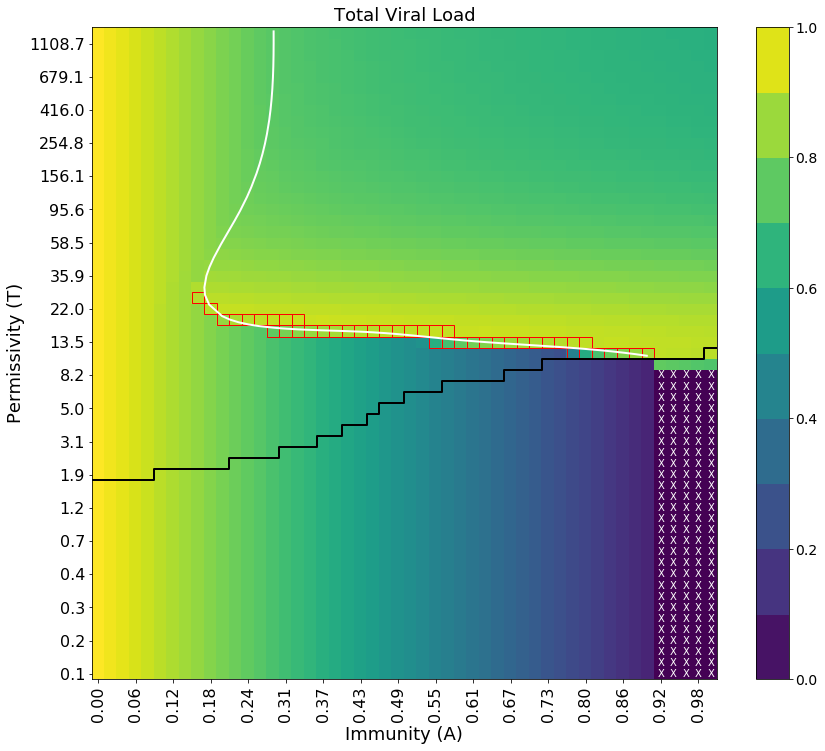

In [15]:
plt.close()
plt.figure(figsize=(14,12))
plt.pcolormesh((np.sum(f['psi_r'][:,:,-1],axis=2) + 
                f['pop_size'][:,:,-1]/20000) * np.all(f['pop_size'][:,:] > 1e-8, axis=2), 
               vmin=0, vmax=1.0, cmap='viridis')
cbar = plt.colorbar(boundaries=np.asarray([0.1 * _ for _ in range(11)]))
cbar.ax.tick_params(labelsize=14)

plt.title('Total Viral Load', size=18)
plt.xticks(0.5 + 3*np.arange(len(imm_list[::3])), 
           ['{:.2f}'.format(_) for _ in imm_vals[::3]], size=16, rotation=90)
plt.yticks(0.5 + 3*np.arange(len(temp_list[::3])), 
           ['{:.1f}'.format(_) for _ in temp_vals[::3]], size=16)
plt.xlabel('Immunity (A)', size=18, y=0.9)
plt.ylabel('Permissivity (T)', size=18)
plt.plot(out[0], out[1], c='white', ls='-', lw=2)
plt.plot(nat_ex_bound[1].tolist() + [nat_ex_bound[1][-1] + 1], 
         (nat_ex_bound[0] + 1).tolist() + [nat_ex_bound[0][-1] + 1], c='k', lw=2)

for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if (numpeaks[y, x] == 2) and (x != 0):
            plt.gca().add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1))
            
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if np.any(f['pop_size'][y, x] < 1e-8):
            plt.text(x + 0.5, y + 0.5, 'X',
                     color='white',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )

plt.show()
plt.close()

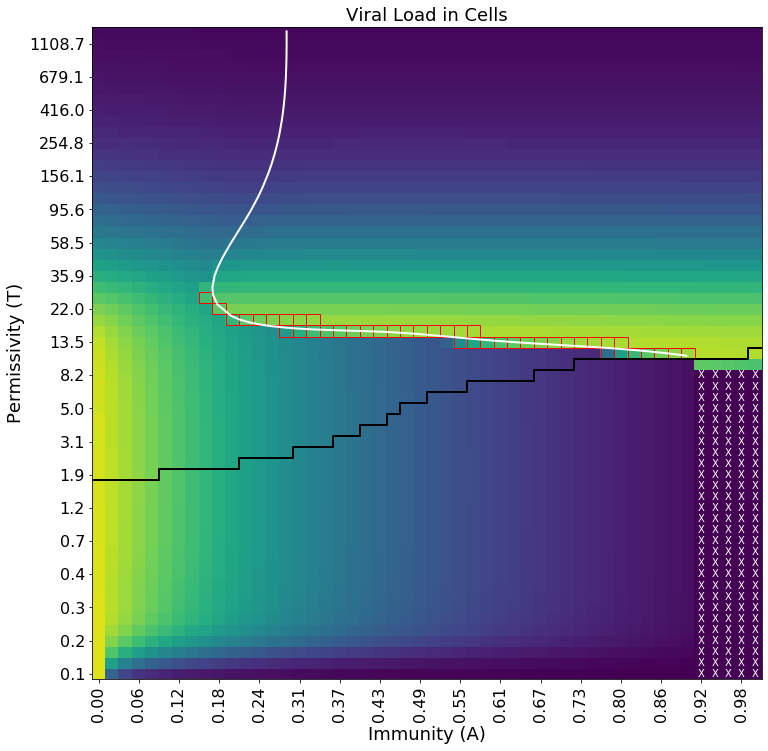

In [16]:
plt.close()
plt.figure(figsize=(12,12))
plt.pcolormesh(np.sum(f['psi_r'][:,:,-1],axis=2) * np.all(f['pop_size'][:,:] > 1e-8, axis=2),
               vmin=0, vmax=1.0, cmap='viridis')
plt.title('Viral Load in Cells', size=18)
plt.xticks(0.5 + 3*np.arange(len(imm_list[::3])), 
           ['{:.2f}'.format(_) for _ in imm_vals[::3]], size=16, rotation=90)
plt.yticks(0.5 + 3*np.arange(len(temp_list[::3])), 
           ['{:.1f}'.format(_) for _ in temp_vals[::3]], size=16)
plt.xlabel('Immunity (A)', size=18, y=0.9)
plt.ylabel('Permissivity (T)', size=18)
plt.plot(out[0], out[1], c='white', ls='-', lw=2)
plt.plot(nat_ex_bound[1].tolist() + [nat_ex_bound[1][-1] + 1], 
         (nat_ex_bound[0] + 1).tolist() + [nat_ex_bound[0][-1] + 1], c='k', lw=2)
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if (numpeaks[y, x] == 2) and (x != 0):
            plt.gca().add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1))
            
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if np.any(f['pop_size'][y, x] < 1e-8):
            plt.text(x + 0.5, y + 0.5, 'X',
                     color='white',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
plt.show()
plt.close()

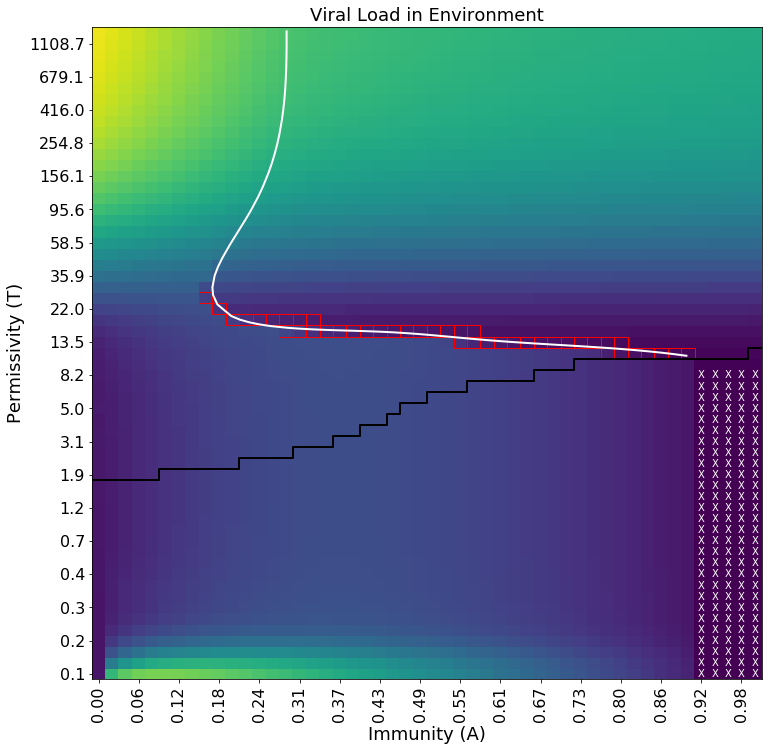

In [17]:
plt.close()
plt.figure(figsize=(12,12))
plt.pcolormesh(f['pop_size'][:,:,-1]/20000 * np.all(f['pop_size'][...] > 1e-8, axis=2)
               , vmin=0, vmax=1.0, cmap='viridis')
plt.title('Viral Load in Environment', size=18)
plt.xticks(0.5 + 3*np.arange(len(imm_list[::3])), 
           ['{:.2f}'.format(_) for _ in imm_vals[::3]], size=16, rotation=90)
plt.yticks(0.5 + 3*np.arange(len(temp_list[::3])), 
           ['{:.1f}'.format(_) for _ in temp_vals[::3]], size=16)
plt.xlabel('Immunity (A)', size=18, y=0.9)
plt.ylabel('Permissivity (T)', size=18)
plt.plot(out[0], out[1], c='white', ls='-', lw=2)
plt.plot(nat_ex_bound[1].tolist() + [nat_ex_bound[1][-1] + 1], 
         (nat_ex_bound[0] + 1).tolist() + [nat_ex_bound[0][-1] + 1], c='k', lw=2)
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if (numpeaks[y, x] == 2) and (x != 0):
            plt.gca().add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1))
            
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if np.any(f['pop_size'][y, x] < 1e-8):
            plt.text(x + 0.5, y + 0.5, 'X',
                     color='white',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
plt.show()
plt.close()

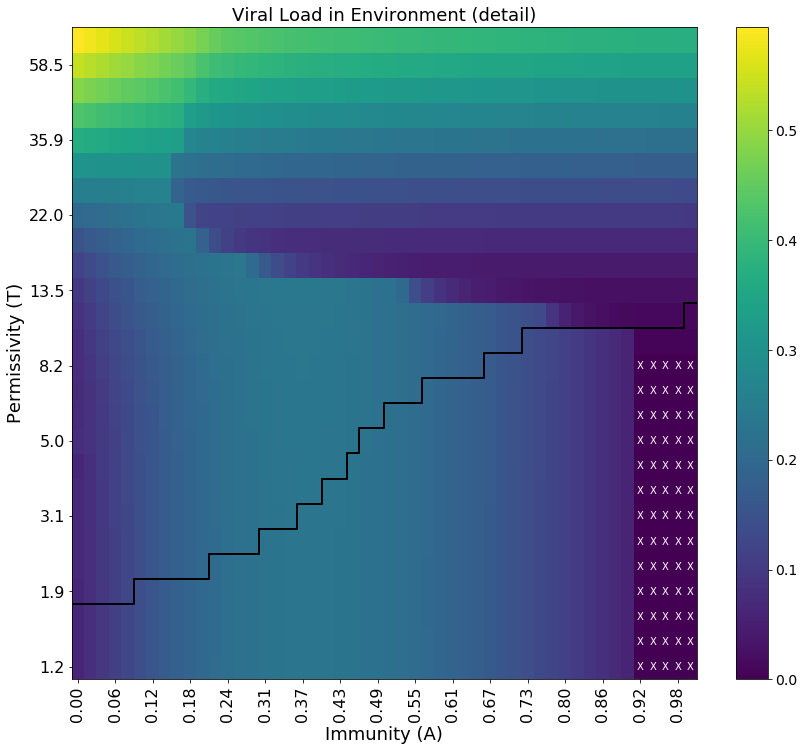

In [25]:
plt.close()
plt.figure(figsize=(14,12))
plt.pcolormesh((1./20000) * f['pop_size'][15:41,:,-1] * np.all(f['pop_size'][15:41,:,:] > 1e-8, axis=2)
               ,  cmap='viridis')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=14)
plt.plot(nat_ex_bound[1].tolist() + [nat_ex_bound[1][-1] + 1], 
         (nat_ex_bound[0] - 14).tolist() + [nat_ex_bound[0][-1] - 14], c='k', lw=2)
plt.title('Viral Load in Environment (detail)', size=18)
plt.xticks(0.5 + 3*np.arange(len(imm_list[::3])), 
           ['{:.2f}'.format(_) for _ in imm_vals[::3]], size=16, rotation=90)
plt.yticks(0.5 + 3*np.arange(len(temp_list[15:41:3])), 
           ['{:.1f}'.format(_) for _ in temp_vals[15:41:3]], size=16)
plt.xlabel('Immunity (A)', size=18, y=0.9)
plt.ylabel('Permissivity (T)', size=18)
           
for y in list(range(len(temp_list)))[15:41]:
    for x in range(len(imm_list)):
        if np.any(f['pop_size'][y, x] < 1e-8):
            plt.text(x + 0.5, y + 0.5 - 15, 'X',
                     color='white',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )

plt.show()
plt.close()

## Iterations to convergence

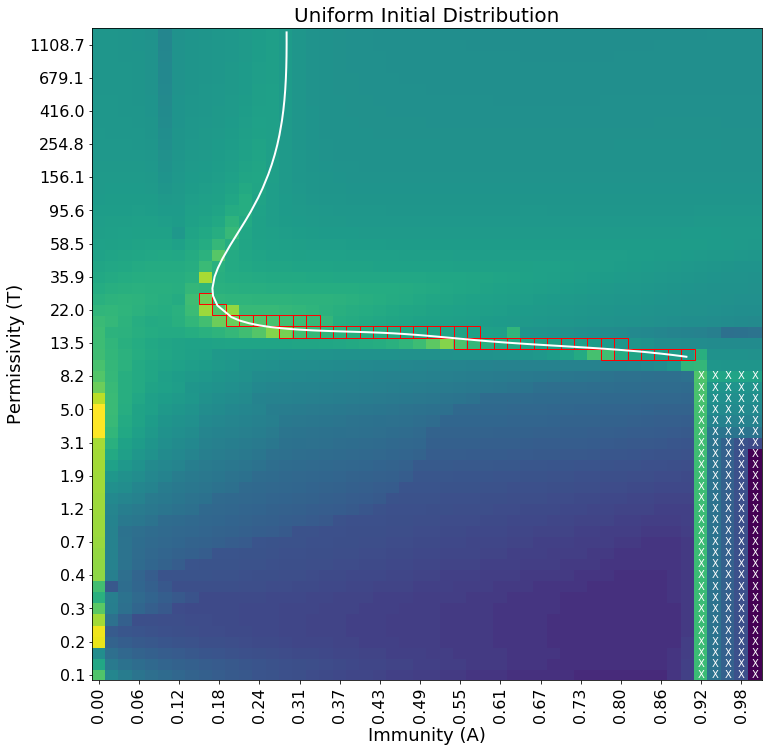

In [19]:
import matplotlib as mpl
current_cmap = mpl.cm.get_cmap()
current_cmap.set_bad(color='black')
plt.close()
plt.figure(figsize=(12,12))
plt.pcolormesh(np.log10(last_iter_with), vmin=0, vmax=5, cmap='viridis')
plt.title('Uniform Initial Distribution', size=20)
plt.xticks(0.5 + 3*np.arange(len(imm_list[::3])), 
           ['{:.2f}'.format(_) for _ in imm_vals[::3]], size=16, rotation=90)
plt.yticks(0.5 + 3*np.arange(len(temp_list[::3])), 
           ['{:.1f}'.format(_) for _ in temp_vals[::3]], size=16)
plt.xlabel('Immunity (A)', size=18, y=0.9)
plt.ylabel('Permissivity (T)', size=18)
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if np.any(f['pop_size'][y, x] < 1e-8):
            plt.text(x + 0.5, y + 0.5, 'X',
                     color='white',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
plt.plot(out[0], out[1], c='white', ls='-', lw=2)
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if (numpeaks[y, x] == 2) and (x != 0):
            plt.gca().add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1))
            
plt.show()
plt.close()


<ipython-input-20-040d7bdec154>:6: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(np.log10(last_iter_with_nat), vmin=0, vmax=5, cmap='viridis')


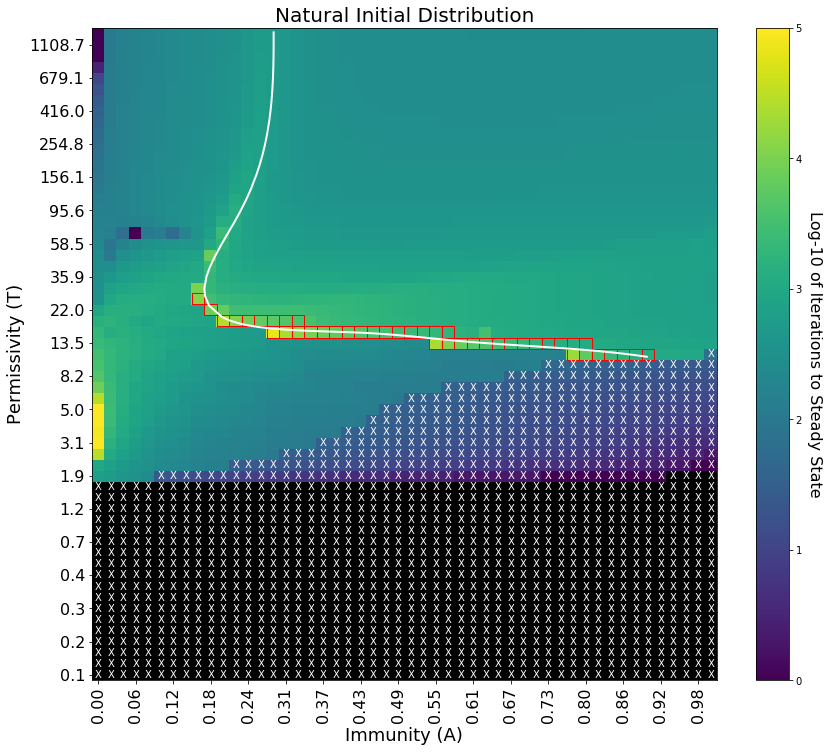

In [20]:
import matplotlib as mpl
current_cmap = mpl.cm.get_cmap()
current_cmap.set_bad(color='black')
plt.close()
plt.figure(figsize=(14,12))
plt.pcolormesh(np.log10(last_iter_with_nat), vmin=0, vmax=5, cmap='viridis')
plt.colorbar().set_label('Log-10 of Iterations to Steady State', rotation=270, size=16, labelpad=20)
plt.title('Natural Initial Distribution', size=20)
plt.xticks(0.5 + 3*np.arange(len(imm_list[::3])), 
           ['{:.2f}'.format(_) for _ in imm_vals[::3]], size=16, rotation=90)
plt.yticks(0.5 + 3*np.arange(len(temp_list[::3])), 
           ['{:.1f}'.format(_) for _ in temp_vals[::3]], size=16)
plt.xlabel('Immunity (A)', size=18, y=1.5)
plt.ylabel('Permissivity (T)', size=18)
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if np.any(f_nat['pop_size'][y, x] < 1e-8):
            plt.text(x + 0.5, y + 0.5, 'X',
                     color='white',
                     horizontalalignment='center',
                     verticalalignment='center',
                     )
plt.plot(out[0], out[1], c='white', ls='-', lw=2)
for y in range(len(temp_list)):
    for x in range(len(imm_list)):
        if (numpeaks[y, x] == 2) and (x != 0):
            plt.gca().add_patch(Rectangle((x, y), 1, 1, fill=False, edgecolor='red', lw=1))
            
plt.show()
plt.close()


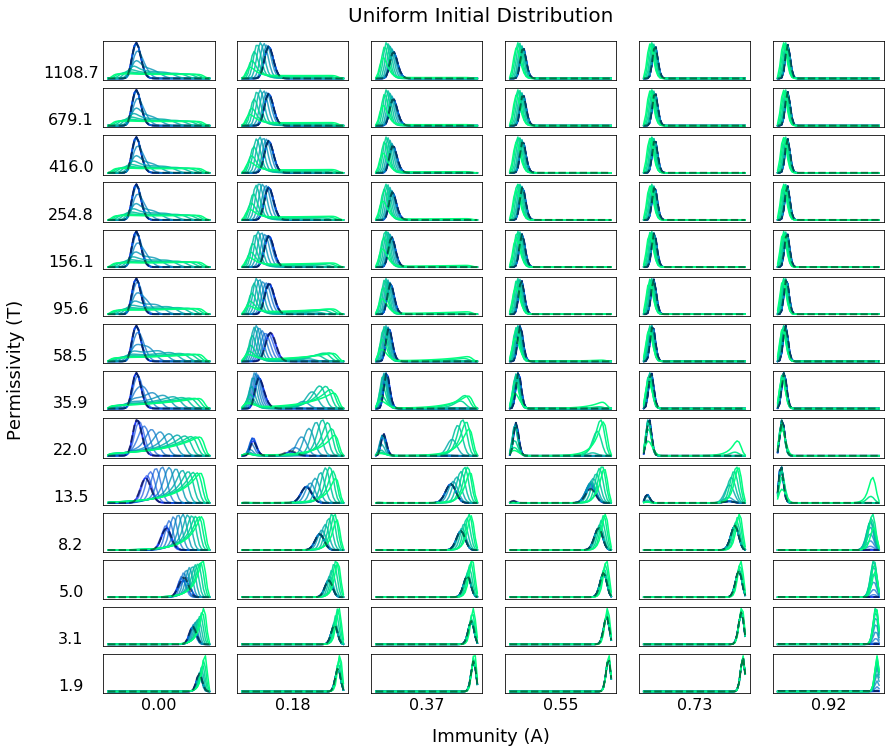

In [21]:
start, end, jump = 1, 482, 40
fs = [1, 1]
for _ in range(15):
    fs.append(fs[-1] + fs[-2])
cmap = plt.get_cmap('winter')
aspace = np.linspace(0.5, 1, len(range(start,end,jump)))
ctu = cmap(np.linspace(0, 1, len(range(start,end,jump))))
plt.close()
fig, axs = plt.subplots(int(len(temp_list) / 4), 6, sharex=True, sharey=False, figsize=(14,12))
for i in range(int(len(temp_list) / 4)):
    axs[i, 0].set_ylabel('{:.1f}'.format(temp_vals[len(temp_list) - 2 - 3*i]), 
                         rotation='horizontal', position=(0, 0), labelpad=32, size=16)
    for j in range(0, 6):
        for k in enumerate(range(start,end,jump)):
            if i == int(len(temp_list) / 4) - 1:
                axs[i, j].set_xlabel('{:.2f}'.format(imm_vals[9*j]), size=16)
            im = axs[i, j].plot(
                f['prob_dists'][len(temp_list) - 2 - 3*i, 9*j,fs[-1 if k[0] == 0 else -k[0]]] * 
                (f['prob_dists'][len(temp_list) - 2 - 3*i, 9*j,fs[-1 if k[0] == 0 else -k[0]]] > 1e-8) *
                f['pop_size'][len(temp_list) - 2 - 3*i, 9*j,fs[-1 if k[0] == 0 else -k[0]]], c=ctu[k[0]], alpha=aspace[k[0]])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
        axs[i,j].plot(f['prob_dists'][len(temp_list) - 2 - 3*i, 9*j, -1] * 
                f['pop_size'][len(temp_list) - 2 - 3*i, 9*j, -1] * 
                np.all(f['pop_size'][len(temp_list) - 2 - 3*i, 9*j] > 1e-8), 
                      c='k', ls='--', lw=2, alpha=0.5)
fig.suptitle('Uniform Initial Distribution', size=20, y=0.92)
fig.text(0.51, 0.07, 'Immunity (A)', ha='center', size=18)
fig.text(0.03, 0.5, 'Permissivity (T)', va='center', rotation='vertical', size=18)
plt.show()
plt.close()

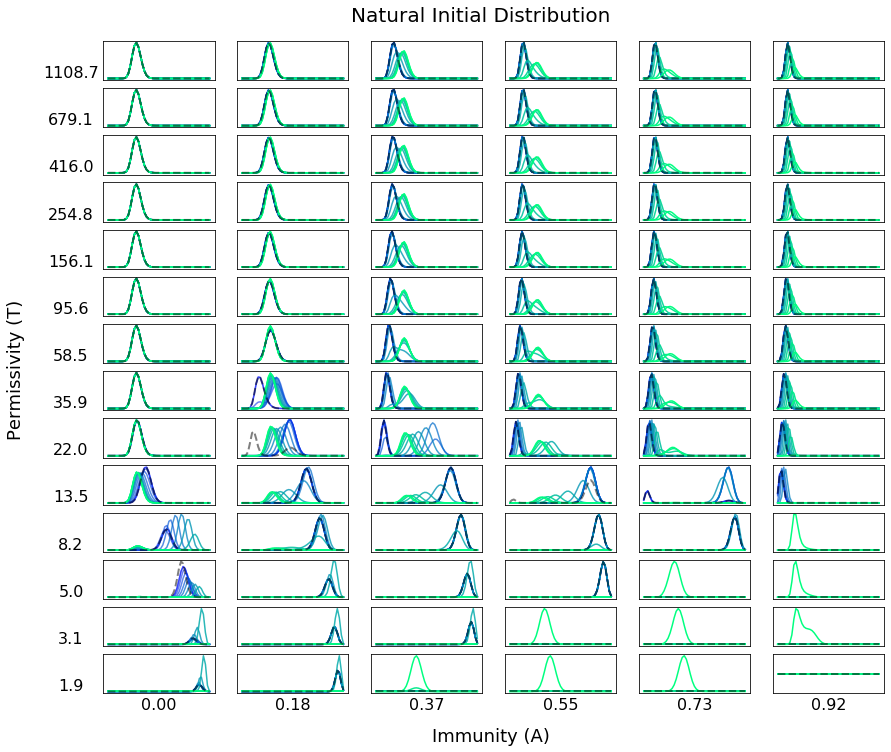

In [22]:
start, end, jump = 1, 482, 40
fs = [1, 1]
for _ in range(15):
    fs.append(fs[-1] + fs[-2])
cmap = plt.get_cmap('winter')
aspace = np.linspace(0.5, 1, len(range(start,end,jump)))
ctu = cmap(np.linspace(0, 1, len(range(start,end,jump))))
plt.close()
fig, axs = plt.subplots(int(len(temp_list) / 4), 6, sharex=True, sharey=False, figsize=(14,12))
for i in range(int(len(temp_list) / 4)):
    axs[i, 0].set_ylabel('{:.1f}'.format(temp_vals[len(temp_list) - 2 - 3*i]), 
                         rotation='horizontal', position=(0, 0), labelpad=32, size=16)
    for j in range(0, 6):
        for k in enumerate(range(start,end,jump)):
            if i == int(len(temp_list) / 4) - 1:
                axs[i, j].set_xlabel('{:.2f}'.format(imm_vals[9*j]), size=16)
            im = axs[i, j].plot(
                f_nat['prob_dists'][len(temp_list) - 2 - 3*i, 9*j,fs[-1 if k[0] == 0 else -k[0]]] * 
                (f_nat['prob_dists'][len(temp_list) - 2 - 3*i, 9*j,fs[-1 if k[0] == 0 else -k[0]]] > 1e-8) *
                f_nat['pop_size'][len(temp_list) - 2 - 3*i, 9*j,fs[-1 if k[0] == 0 else -k[0]]], c=ctu[k[0]], alpha=aspace[k[0]])
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])
        axs[i,j].plot(f_nat['prob_dists'][len(temp_list) - 2 - 3*i, 9*j, -1] * 
                f_nat['pop_size'][len(temp_list) - 2 - 3*i, 9*j, -1] * 
                np.all(f_nat['pop_size'][len(temp_list) - 2 - 3*i, 9*j, -1] > 1e-8), 
                      c='k', ls='--', lw=2, alpha=0.5)
fig.suptitle('Natural Initial Distribution', size=20, y=0.92)
fig.text(0.51, 0.07, 'Immunity (A)', ha='center', size=18)
fig.text(0.03, 0.5, 'Permissivity (T)', va='center', rotation='vertical', size=18)
plt.show()
plt.close()

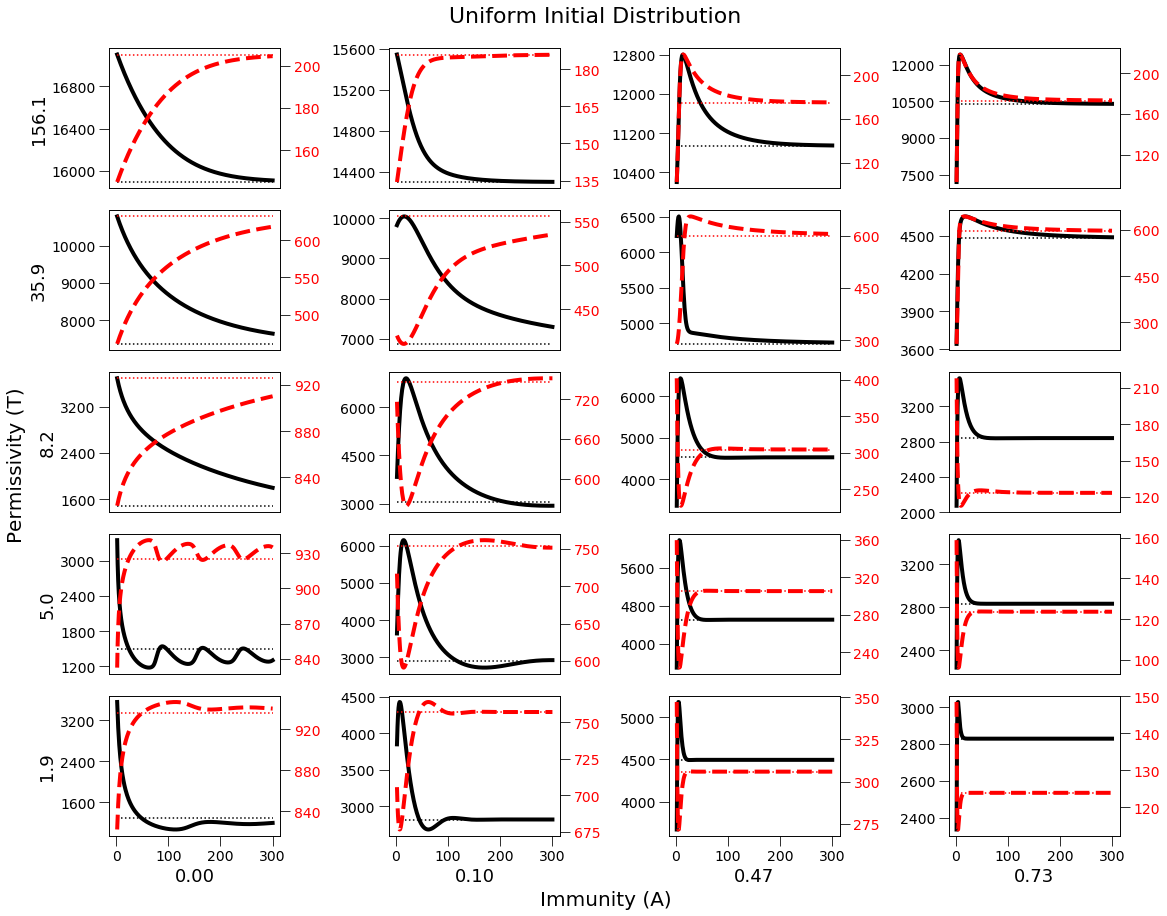

In [22]:
plt.close()

t_l = [45, 36, 27, 24, 18]
a_l = [0, 5, 23, 36]

time_vals = np.arange(2,301)
lw_val = 4

start_iter = 10
fig, axs = plt.subplots(len(t_l), len(a_l), figsize=(16,12))
fig.suptitle('Uniform Initial Distribution', size=22, y=1.03)
fig.text(0.51, -0.01, 'Immunity (A)', ha='center', size=20)
fig.text(-0.01, 0.5, 'Permissivity (T)', va='center', rotation='vertical', size=20)


for i in range(len(t_l)):
    for j in range(len(a_l)):
        if (j == 0) & (i == 3):
            ln1 = axs[i][j].plot(range(2,2001),f['pop_size'][t_l[i],a_l[j],2:2001], 
                                 'k-', lw=lw_val, label='In Environment')
            axs[i][j].plot([time_vals[0], 2000], [f['pop_size'][t_l[i],a_l[j], -1], 
                              f['pop_size'][t_l[i],a_l[j], -1]], ls=':', 
                   c='k', label='Environment Last Iter')
        else:
            if (np.sum(f['psi_r'][t_l[i],a_l[j],-1]) < 0.0) & (f['pop_size'][t_l[i],a_l[j],-1] == 0.0):
                ln1 = axs[i][j].plot(time_vals,f['pop_size'][t_l[i],a_l[j],time_vals] * np.asarray(
                [np.heaviside(-1*int(
                    np.any(f['psi_r'][t_l[i],a_l[j],_] < 0)), 1) for _ in time_vals]),
                               'k-', lw=lw_val, label='In Environment')
                axs[i][j].set_ylim([-2000, 22000])
            else:
                ln1 = axs[i][j].plot(time_vals,f['pop_size'][t_l[i],a_l[j],time_vals], 
                               'k-', lw=lw_val, label='In Environment')
                

        ax2 = axs[i][j].twinx()
        # if is for oscillatory case
        if (j == 0) & (i == 3):
            ln2 = ax2.plot(range(2,2001),
                           [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                                   ) for _ in range(2,2001)],
                           'r--', lw=lw_val, label='Inside Cells')

            ax2.plot([time_vals[0], 2000], [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1]), 
                                  1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1])], ls=':', 
                       c='r', label='Inside Cells Last Iter')
        else:
            if (np.sum(f['psi_r'][t_l[i],a_l[j],-1]) < 0.0) & (f['pop_size'][t_l[i],a_l[j],-1] == 0.0):
                ln2 = ax2.plot(time_vals,[
                    1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                 ) * np.heaviside(
                        -1*int(np.any(f['psi_r'][t_l[i],a_l[j],_] < 0)), 1
                    ) for _ in time_vals], 'r--', lw=lw_val, label='Inside Cells')
                ax2.set_ylim([-100, 1100])
            else:
                ln2 = ax2.plot(time_vals,[1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                             ) for _ in time_vals],
                               'r--', lw=lw_val, label='Inside Cells')
                axs[i][j].plot([time_vals[0], time_vals[-1]], [f['pop_size'][t_l[i],a_l[j], -1], 
                                      f['pop_size'][t_l[i],a_l[j], -1]], ls=':', 
                           c='k', label='Environment Last Iter')
                ax2.plot([time_vals[0], time_vals[-1]], [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1]), 
                                      1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1])], ls=':', 
                           c='r', label='Inside Cells Last Iter')
        if j == 0:
            axs[i][j].set_ylabel('{:.1f}'.format(temp_vals[t_l[i]]),
                              fontsize=18)
        axs[i][j].tick_params(axis='y', labelcolor='k', labelsize=14, size=10)
        ax2.tick_params(axis='y', labelcolor='r', labelsize=14, size=10)
        axs[i][j].ticklabel_format(useOffset=False)
        ax2.ticklabel_format(useOffset=False)
        axs[i][j].yaxis.set_major_locator(plt.MaxNLocator(4))
        ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[i][j].xaxis.set_major_locator(plt.MaxNLocator(4))
        
        if i == (len(t_l) - 1):
            axs[i][j].set_xlabel('{:.2f}'.format(imm_vals[a_l[j]]),
                          fontsize=18)
            axs[i][j].tick_params(axis='both', labelsize=14, size=10)
        else:
            # the following code is from user stackoverflow:
            # https://stackoverflow.com/a/12998531
            # and is used with a CC BY-SA 3.0 license
            # as defined here: https://creativecommons.org/licenses/by-sa/3.0/legalcode
            axs[i][j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax2.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()
plt.show()
plt.close()

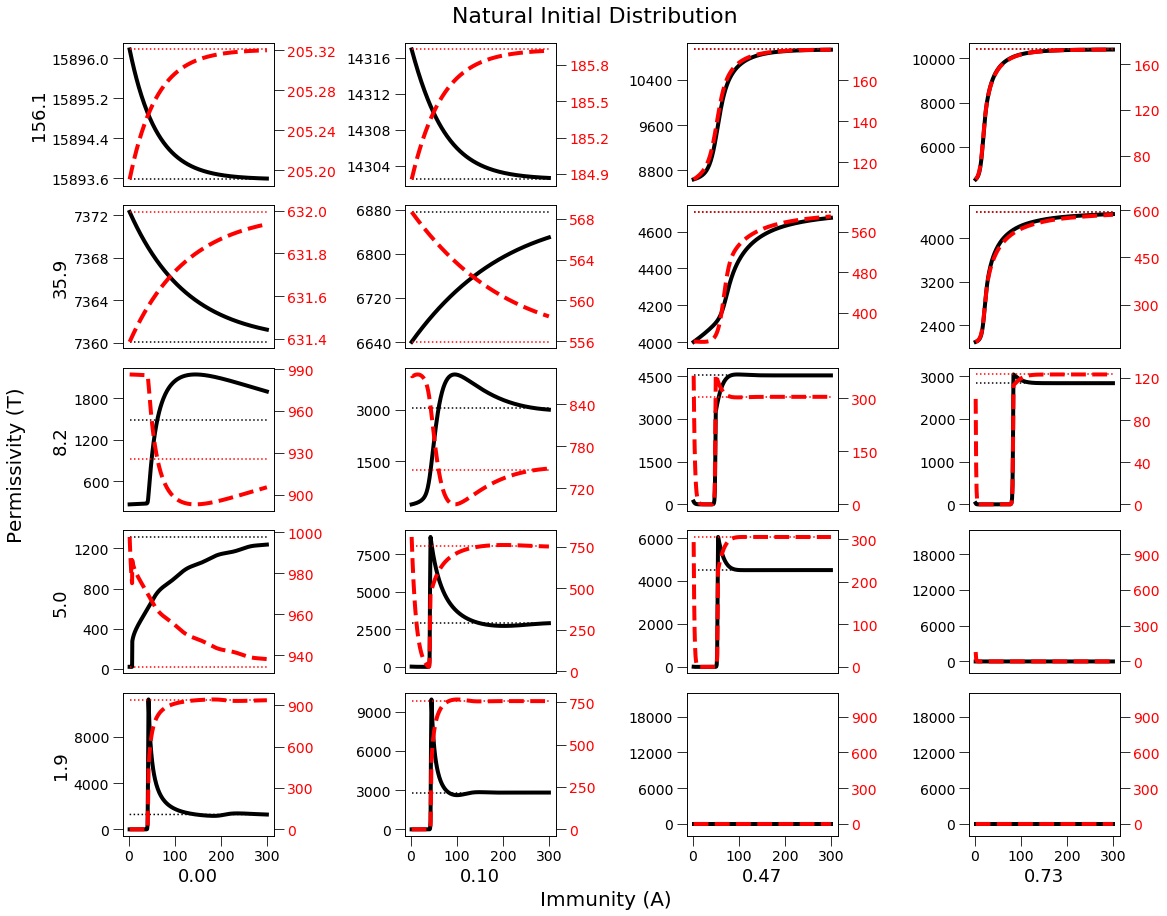

In [23]:
import importlib
importlib.reload(plt)
import matplotlib.gridspec as gridspec
plt.close()
t_l = [45, 36, 27, 24, 18]
a_l = [0, 5, 23, 36]
time_vals = np.arange(2,301)
lw_val = 4
start_iter = 10
fig, axs = plt.subplots(len(t_l), len(a_l), figsize=(16,12))
fig.suptitle('Natural Initial Distribution', size=22, y=1.03)
fig.text(0.51, -0.01, 'Immunity (A)', ha='center', size=20)
fig.text(-0.01, 0.5, 'Permissivity (T)', va='center', rotation='vertical', size=20)

for i in range(len(t_l)):
    for j in range(len(a_l)):
        if (j == 0) & (i == 3):
            ln1 = axs[i][j].plot(range(2,2001),f_nat['pop_size'][t_l[i],a_l[j],2:2001], 
                                 'k-', lw=lw_val, label='In Environment')
            axs[i][j].plot([time_vals[0], 2000], [f_nat['pop_size'][t_l[i],a_l[j], -1], 
                              f_nat['pop_size'][t_l[i],a_l[j], -1]], ls=':', 
                   c='k', label='Environment Last Iter')
        else:
            if (np.sum(f_nat['psi_r'][t_l[i],a_l[j],-1]) < 0.0) & (f_nat['pop_size'][t_l[i],a_l[j],-1] == 0.0):
                ln1 = axs[i][j].plot(time_vals,f_nat['pop_size'][t_l[i],a_l[j],time_vals] * np.asarray(
                [np.heaviside(-1*int(
                    np.any(f_nat['psi_r'][t_l[i],a_l[j],_] < 0)), 1) for _ in time_vals]),
                               'k-', lw=lw_val, label='In Environment')
                axs[i][j].set_ylim([-2000, 22000])
            else:
                ln1 = axs[i][j].plot(time_vals,f_nat['pop_size'][t_l[i],a_l[j],time_vals], 
                               'k-', lw=lw_val, label='In Environment')
                
        ax2 = axs[i][j].twinx()
        if (j == 0) & (i == 3):
            ln2 = ax2.plot(range(2,2001),
                           [1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],_]
                                                   ) for _ in range(2, 2001)],
                           'r--', lw=lw_val, label='Inside Cells')

            ax2.plot([time_vals[0], 2000], [1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],-1]), 
                                  1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],-1])], ls=':', 
                       c='r', label='Inside Cells Last Iter')
        else:
            if (np.sum(f_nat['psi_r'][t_l[i],a_l[j],-1]) < 0.0) & (f_nat['pop_size'][t_l[i],a_l[j],-1] == 0.0):
                ln2 = ax2.plot(time_vals,[
                    1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],_]
                                 ) * np.heaviside(
                        -1*int(np.any(f_nat['psi_r'][t_l[i],a_l[j],_] < 0)), 1
                    ) for _ in time_vals], 'r--', lw=lw_val, label='Inside Cells')
                ax2.set_ylim([-100, 1100])
            else:
                ln2 = ax2.plot(time_vals,[1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],_]
                                             ) for _ in time_vals],
                               'r--', lw=lw_val, label='Inside Cells')
                axs[i][j].plot([time_vals[0], time_vals[-1]], [f_nat['pop_size'][t_l[i],a_l[j], -1], 
                                      f['pop_size'][t_l[i],a_l[j], -1]], ls=':', 
                           c='k', label='Environment Last Iter')
                ax2.plot([time_vals[0], time_vals[-1]], [1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],-1]), 
                                      1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],-1])], ls=':', 
                           c='r', label='Inside Cells Last Iter')

        if j == 0:
            axs[i][j].set_ylabel('{:.1f}'.format(temp_vals[t_l[i]]),
                              fontsize=18)
        axs[i][j].tick_params(axis='y', labelcolor='k', labelsize=14, size=10)
        ax2.tick_params(axis='y', labelcolor='r', labelsize=14, size=10)
        axs[i][j].ticklabel_format(useOffset=False)
        ax2.ticklabel_format(useOffset=False)
        axs[i][j].yaxis.set_major_locator(plt.MaxNLocator(4))
        ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[i][j].xaxis.set_major_locator(plt.MaxNLocator(4))
        
        if i == (len(t_l) - 1):
            axs[i][j].set_xlabel('{:.2f}'.format(imm_vals[a_l[j]]),
                          fontsize=18)
            axs[i][j].tick_params(axis='both', labelsize=14, size=10)
        else:
            # the following code is from user stackoverflow:
            # https://stackoverflow.com/a/12998531
            # and is used with a CC BY-SA 3.0 license
            # as defined here: https://creativecommons.org/licenses/by-sa/3.0/legalcode            
            axs[i][j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax2.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()
plt.show()
plt.close()

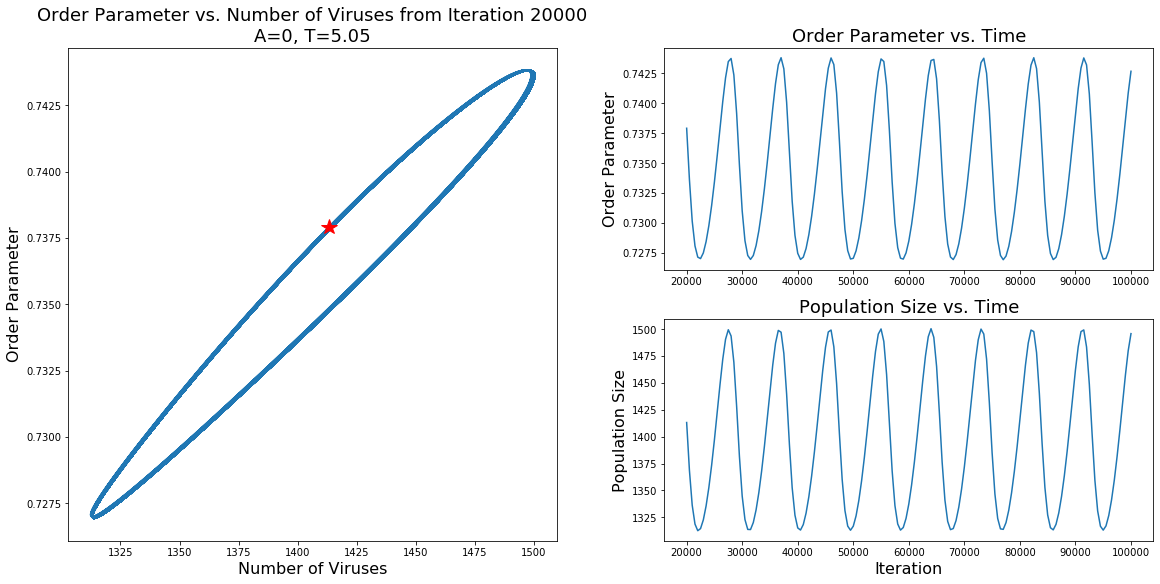

In [133]:
i, j = 24, 0
perorb_ordpar = (np.sum(np.arange(51))/50.) * np.average(f['prob_dists'][i,j], 
                                          weights = np.arange(51), axis=1)
step = 500
start = 20000
# print(type(i), type(j), type(step), type(start))
plt.close()
fig2 = plt.figure(figsize=(16,8), constrained_layout=True)
# plt.title('Characteristics of Stable Orbit Behavior,\nA=0, T={:0.2f}'.format(temp_vals[15]), size=18, y=1.02)
spec2 = gridspec.GridSpec(ncols=6, nrows=2, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[:, :3])
f2_ax1.plot(f['pop_size'][i,j,start:], perorb_ordpar[start:])
f2_ax1.plot(f['pop_size'][i,j,start], perorb_ordpar[start], 'r*', ms=16)
f2_ax1.set_title('Order Parameter vs. Number of Viruses from Iteration {}\nA=0, T={:0.2f}'.format(start, temp_vals[i]), size=18)
f2_ax1.set_xlabel('Number of Viruses', size=16)
f2_ax1.set_ylabel('Order Parameter', size=16)
f2_ax2 = fig2.add_subplot(spec2[0, 3:])
f2_ax2.plot(start+np.arange(0,perorb_ordpar[start:].shape[0], step), perorb_ordpar[start::step])
f2_ax2.set_title('Order Parameter vs. Time', size=18)
f2_ax2.set_ylabel('Order Parameter', size=16)
f2_ax3 = fig2.add_subplot(spec2[1:, 3:])
f2_ax3.plot(start+np.arange(0,f['pop_size'][i,j,start:].shape[0], step), f['pop_size'][i,j,start::step])
f2_ax3.set_title('Population Size vs. Time', size=18)
f2_ax3.set_xlabel('Iteration', size=16)
f2_ax3.set_ylabel('Population Size', size=16)
# plt.savefig(fl0 + 'StableOrbit' + fl1)
plt.show()
plt.close()

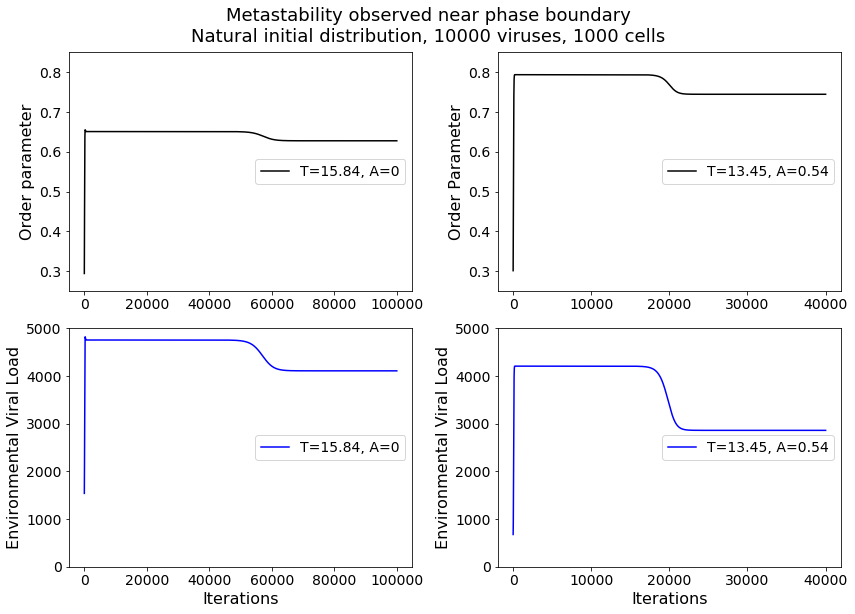

In [38]:
start_iter_14 = 5
start_iter_27 = 5
end_iter_27 = 40000
plt.close()
fig,axs = plt.subplots(2,2,figsize=(12, 8))
axs[0,0].plot(range(start_iter_14,start_iter_14 + f_nat['ord_param'][31,14,start_iter_14:].shape[0]), 
              f_nat['ord_param'][31,14,start_iter_14:], c='black', label='T=15.84, A=0')
axs[0,0].set_ylabel('Order parameter', size=16)
axs[0,0].set_ylim([0.25,0.85])
axs[0,0].legend(loc='right', prop={'size': 14})
axs[0,0].tick_params(axis='both', labelsize=14)
# axs[0,0].set_title('T=15.84, A=0')
axs[1,0].plot(range(start_iter_14,start_iter_14 +  f_nat['pop_size'][31,14,start_iter_14:].shape[0]), 
              f_nat['pop_size'][31,14,start_iter_14:], c='blue', label='T=15.84, A=0')
axs[1,0].set_ylabel('Environmental Viral Load', size=16)
axs[1,0].set_xlabel('Iterations', size=16)
axs[1,0].legend(loc='right', prop={'size': 14})
axs[1,0].tick_params(axis='both', labelsize=14)
axs[1,0].set_ylim([0,5000])
# axs[1,0].set_ylim([0, 4800])
axs[0,1].plot(range(start_iter_27, end_iter_27), 
              f_nat['ord_param'][30,27,start_iter_27:end_iter_27], c='black', label='T=13.45, A=0.54')
axs[0,1].set_ylabel('Order Parameter', size=16)
axs[0,1].set_ylim([0.25,0.85])
axs[0,1].legend(loc='right', prop={'size': 14})
axs[0,1].tick_params(axis='both', labelsize=14)
axs[1,1].plot(range(start_iter_27,end_iter_27), 
              f_nat['pop_size'][30,27,start_iter_27:end_iter_27], c='blue', label='T=13.45, A=0.54')
axs[1,1].set_ylabel('Environmental Viral Load', size=16)
axs[1,1].set_xlabel('Iterations', size=16)
axs[1,1].tick_params(axis='both', labelsize=14)
axs[1,1].legend(loc='right', prop={'size': 14})
axs[1,1].set_ylim([0,5000])
plt.suptitle('Metastability observed near phase boundary\nNatural initial distribution, 10000 viruses, 1000 cells', size=18, y=1.06)
plt.tight_layout()
plt.show()
plt.close()
# plt.close()
# fig,axs = plt.subplots(2,1,figsize=(8,8))
# axs[0].plot(range(1000,1000 + ord_param_with_dyn_nat[30,27,1000:].shape[0]), ord_param_with_dyn_nat[30,27,1000:])
# axs[0].set_title('Order Parameter')
# axs[1].plot(range(1000,1000 + f_nat['pop_size'][30,27,1000:].shape[0]), f_nat['pop_size'][30,27,1000:])
# axs[1].set_title('Environmental Viral Load')
# plt.suptitle('Metastability observed near phase boundary\nNatural initial distribution, T=13.45, A=0.54, 10000 viruses, 1000 cells', size=18, y=0.98)
# plt.show()
# plt.close()
# plt.close()
# fig,axs = plt.subplots(2,1,figsize=(8,8))
# axs[0].plot(range(1000,1000 + ord_param_with_dyn[36,8,1000:].shape[0]), ord_param_with_dyn[36,8,1000:])
# axs[0].set_title('Order Parameter')
# axs[1].plot(range(1000,1000 + f['pop_size'][36,8,1000:].shape[0]), f['pop_size'][36,8,1000:])
# axs[1].set_title('Environmental Viral Load')
# plt.suptitle('Metastability observed near phase boundary\nNatural initial distribution, T=13.45, A=0.54, 10000 viruses, 1000 cells', size=18, y=0.98)
# plt.show()
# plt.close()

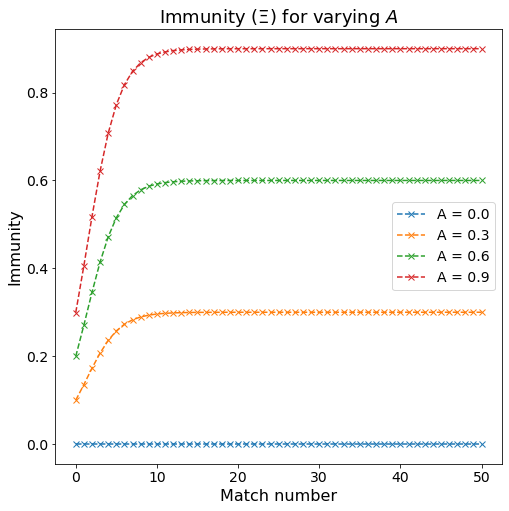

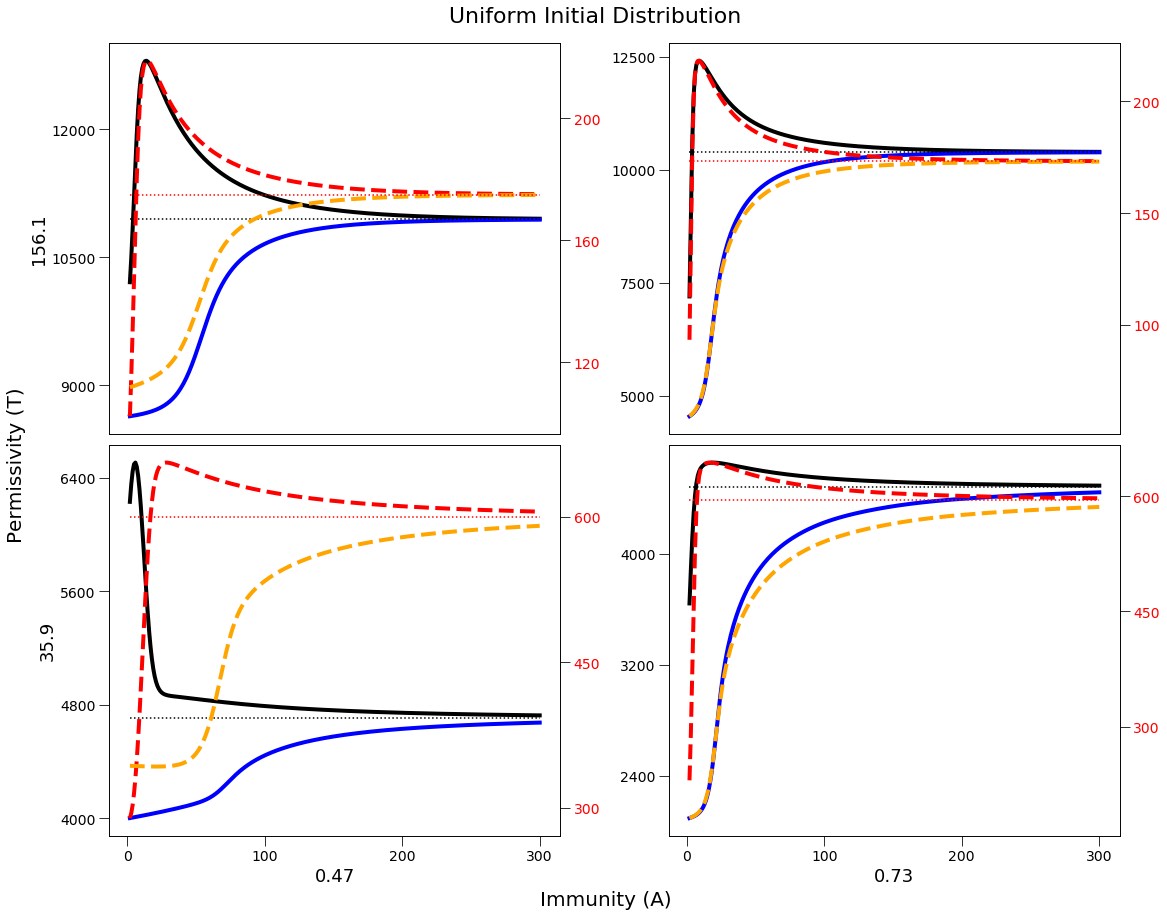

In [13]:
plt.close()

t_l = [45, 36]
a_l = [23, 36]

time_vals = np.arange(2,301)
lw_val = 4

start_iter = 10
fig, axs = plt.subplots(len(t_l), len(a_l), figsize=(16,12))
fig.suptitle('Uniform Initial Distribution', size=22, y=1.03)
fig.text(0.51, -0.01, 'Immunity (A)', ha='center', size=20)
fig.text(-0.01, 0.5, 'Permissivity (T)', va='center', rotation='vertical', size=20)


for i in range(len(t_l)):
    for j in range(len(a_l)):
        if (j == 0) & (i == 3):
            ln1 = axs[i][j].plot(range(2,2001),f['pop_size'][t_l[i],a_l[j],2:2001], 
                                 'k-', lw=lw_val, label='Env Uni')
            ln1n = axs[i][j].plot(range(2,2001),f_nat['pop_size'][t_l[i],a_l[j],2:2001], 
                                 'b-', lw=lw_val, label='Env Nat')
            axs[i][j].plot([time_vals[0], 2000], [f['pop_size'][t_l[i],a_l[j], -1], 
                              f['pop_size'][t_l[i],a_l[j], -1]], ls=':', 
                   c='k', label='Environment Last Iter')
        else:
            if (np.sum(f['psi_r'][t_l[i],a_l[j],-1]) < 0.0) & (f['pop_size'][t_l[i],a_l[j],-1] == 0.0):
                ln1 = axs[i][j].plot(time_vals,f['pop_size'][t_l[i],a_l[j],time_vals] * np.asarray(
                [np.heaviside(-1*int(
                    np.any(f['psi_r'][t_l[i],a_l[j],_] < 0)), 1) for _ in time_vals]),
                               'k-', lw=lw_val, label='In Environment')
                axs[i][j].set_ylim([-2000, 22000])
            else:
                ln1 = axs[i][j].plot(time_vals,f['pop_size'][t_l[i],a_l[j],time_vals], 
                               'k-', lw=lw_val, label='In Environment')
                ln1n = axs[i][j].plot(time_vals,f_nat['pop_size'][t_l[i],a_l[j],time_vals], 
                               'b-', lw=lw_val, label='In Environment')
                

        ax2 = axs[i][j].twinx()
        # if is for oscillatory case
        if (j == 0) & (i == 3):
            ln2 = ax2.plot(range(2,2001),
                           [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                                   ) for _ in range(2,2001)],
                           'r--', lw=lw_val, label='Inside Uni')
            ln2n = ax2.plot(range(2,2001),
                           [1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],_]
                                                   ) for _ in range(2,2001)],
                           c='orange', ls='--', lw=lw_val, label='Inside Nat')
            ax2.plot([time_vals[0], 2000], [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1]), 
                                  1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1])], ls=':', 
                       c='r', label='Inside Cells Last Iter')
        else:
            if (np.sum(f['psi_r'][t_l[i],a_l[j],-1]) < 0.0) & (f['pop_size'][t_l[i],a_l[j],-1] == 0.0):
                ln2 = ax2.plot(time_vals,[
                    1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                 ) * np.heaviside(
                        -1*int(np.any(f['psi_r'][t_l[i],a_l[j],_] < 0)), 1
                    ) for _ in time_vals], 'r--', lw=lw_val, label='Inside Cells')
                ax2.set_ylim([-100, 1100])
            else:
                ln2 = ax2.plot(time_vals,[1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                             ) for _ in time_vals],
                               'r--', lw=lw_val, label='Inside Cells')
                ln2n = ax2.plot(time_vals,[1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],_]
                                             ) for _ in time_vals],
                               c='orange', ls='--', lw=lw_val, label='Inside Cells')                
                axs[i][j].plot([time_vals[0], time_vals[-1]], [f['pop_size'][t_l[i],a_l[j], -1], 
                                      f['pop_size'][t_l[i],a_l[j], -1]], ls=':', 
                           c='k', label='Environment Last Iter')
                ax2.plot([time_vals[0], time_vals[-1]], [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1]), 
                                      1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1])], ls=':', 
                           c='r', label='Inside Cells Last Iter')
        if j == 0:
            axs[i][j].set_ylabel('{:.1f}'.format(temp_vals[t_l[i]]),
                              fontsize=18)
        axs[i][j].tick_params(axis='y', labelcolor='k', labelsize=14, size=10)
        ax2.tick_params(axis='y', labelcolor='r', labelsize=14, size=10)
        axs[i][j].ticklabel_format(useOffset=False)
        ax2.ticklabel_format(useOffset=False)
        axs[i][j].yaxis.set_major_locator(plt.MaxNLocator(4))
        ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[i][j].xaxis.set_major_locator(plt.MaxNLocator(4))
        
        if i == (len(t_l) - 1):
            axs[i][j].set_xlabel('{:.2f}'.format(imm_vals[a_l[j]]),
                          fontsize=18)
            axs[i][j].tick_params(axis='both', labelsize=14, size=10)
        else:
            # the following code is from user stackoverflow:
            # https://stackoverflow.com/a/12998531
            # and is used with a CC BY-SA 3.0 license
            # as defined here: https://creativecommons.org/licenses/by-sa/3.0/legalcode
            axs[i][j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax2.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()
plt.show()
plt.close()

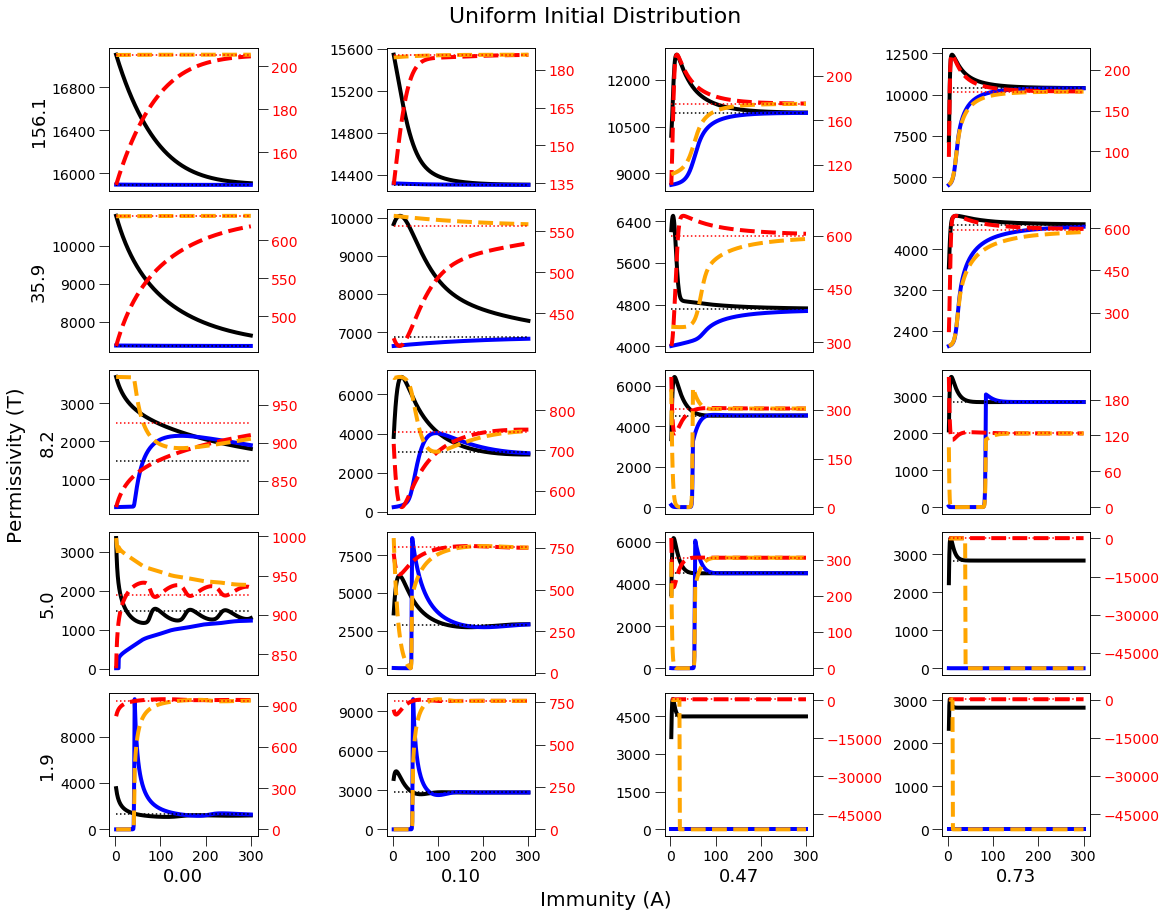

In [14]:
plt.close()

t_l = [45, 36, 27, 24, 18]
a_l = [0, 5, 23, 36]

time_vals = np.arange(2,301)
lw_val = 4

start_iter = 10
fig, axs = plt.subplots(len(t_l), len(a_l), figsize=(16,12))
fig.suptitle('Uniform Initial Distribution', size=22, y=1.03)
fig.text(0.51, -0.01, 'Immunity (A)', ha='center', size=20)
fig.text(-0.01, 0.5, 'Permissivity (T)', va='center', rotation='vertical', size=20)


for i in range(len(t_l)):
    for j in range(len(a_l)):
        if (j == 0) & (i == 3):
            ln1 = axs[i][j].plot(range(2,2001),f['pop_size'][t_l[i],a_l[j],2:2001], 
                                 'k-', lw=lw_val, label='Env Uni')
            ln1n = axs[i][j].plot(range(2,2001),f_nat['pop_size'][t_l[i],a_l[j],2:2001], 
                                 'b-', lw=lw_val, label='Env Nat')
            axs[i][j].plot([time_vals[0], 2000], [f['pop_size'][t_l[i],a_l[j], -1], 
                              f['pop_size'][t_l[i],a_l[j], -1]], ls=':', 
                   c='k', label='Environment Last Iter')
        else:
            if (np.sum(f['psi_r'][t_l[i],a_l[j],-1]) < 0.0) & (f['pop_size'][t_l[i],a_l[j],-1] == 0.0):
                ln1 = axs[i][j].plot(time_vals,f['pop_size'][t_l[i],a_l[j],time_vals] * np.asarray(
                [np.heaviside(-1*int(
                    np.any(f['psi_r'][t_l[i],a_l[j],_] < 0)), 1) for _ in time_vals]),
                               'k-', lw=lw_val, label='In Environment')
                ln1n = axs[i][j].plot(time_vals,f_nat['pop_size'][t_l[i],a_l[j],time_vals] * np.asarray(
                [np.heaviside(-1*int(
                    np.any(f_nat['psi_r'][t_l[i],a_l[j],_] < 0)), 1) for _ in time_vals]),
                               'b-', lw=lw_val, label='In Environment')                
                axs[i][j].set_ylim([-2000, 22000])
            else:
                ln1 = axs[i][j].plot(time_vals,f['pop_size'][t_l[i],a_l[j],time_vals], 
                               'k-', lw=lw_val, label='In Environment')
                ln1n = axs[i][j].plot(time_vals,f_nat['pop_size'][t_l[i],a_l[j],time_vals], 
                               'b-', lw=lw_val, label='In Environment')
                

        ax2 = axs[i][j].twinx()
        # if is for oscillatory case
        if (j == 0) & (i == 3):
            ln2 = ax2.plot(range(2,2001),
                           [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                                   ) for _ in range(2,2001)],
                           'r--', lw=lw_val, label='Inside Uni')
            ln2n = ax2.plot(range(2,2001),
                           [1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],_]
                                                   ) for _ in range(2,2001)],
                           c='orange', ls='--', lw=lw_val, label='Inside Nat')
            ax2.plot([time_vals[0], 2000], [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1]), 
                                  1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1])], ls=':', 
                       c='r', label='Inside Cells Last Iter')
        else:
            if (np.sum(f['psi_r'][t_l[i],a_l[j],-1]) < 0.0) & (f['pop_size'][t_l[i],a_l[j],-1] == 0.0):
                ln2 = ax2.plot(time_vals,[
                    1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                 ) * np.heaviside(
                        -1*int(np.any(f['psi_r'][t_l[i],a_l[j],_] < 0)), 1
                    ) for _ in time_vals], 'r--', lw=lw_val, label='Inside Cells')
                ln2n = ax2.plot(time_vals,[
                    1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],_]
                                 ) * np.heaviside(
                        -1*int(np.any(f_nat['psi_r'][t_l[i],a_l[j],_] < 0)), 1
                    ) for _ in time_vals], c='orange', ls='--', lw=lw_val, label='Inside Cells')                
                ax2.set_ylim([-100, 1100])
            else:
                ln2 = ax2.plot(time_vals,[1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],_]
                                             ) for _ in time_vals],
                               'r--', lw=lw_val, label='Inside Cells')
                ln2n = ax2.plot(time_vals,[1000.0*np.sum(f_nat['psi_r'][t_l[i],a_l[j],_]
                                             ) for _ in time_vals],
                               c='orange', ls='--', lw=lw_val, label='Inside Cells')                
                axs[i][j].plot([time_vals[0], time_vals[-1]], [f['pop_size'][t_l[i],a_l[j], -1], 
                                      f['pop_size'][t_l[i],a_l[j], -1]], ls=':', 
                           c='k', label='Environment Last Iter')
                ax2.plot([time_vals[0], time_vals[-1]], [1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1]), 
                                      1000.0*np.sum(f['psi_r'][t_l[i],a_l[j],-1])], ls=':', 
                           c='r', label='Inside Cells Last Iter')
        if j == 0:
            axs[i][j].set_ylabel('{:.1f}'.format(temp_vals[t_l[i]]),
                              fontsize=18)
        axs[i][j].tick_params(axis='y', labelcolor='k', labelsize=14, size=10)
        ax2.tick_params(axis='y', labelcolor='r', labelsize=14, size=10)
        axs[i][j].ticklabel_format(useOffset=False)
        ax2.ticklabel_format(useOffset=False)
        axs[i][j].yaxis.set_major_locator(plt.MaxNLocator(4))
        ax2.yaxis.set_major_locator(plt.MaxNLocator(4))
        axs[i][j].xaxis.set_major_locator(plt.MaxNLocator(4))
        
        if i == (len(t_l) - 1):
            axs[i][j].set_xlabel('{:.2f}'.format(imm_vals[a_l[j]]),
                          fontsize=18)
            axs[i][j].tick_params(axis='both', labelsize=14, size=10)
        else:
            # the following code is from user stackoverflow:
            # https://stackoverflow.com/a/12998531
            # and is used with a CC BY-SA 3.0 license
            # as defined here: https://creativecommons.org/licenses/by-sa/3.0/legalcode
            axs[i][j].tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off
            ax2.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()
plt.show()
plt.close()

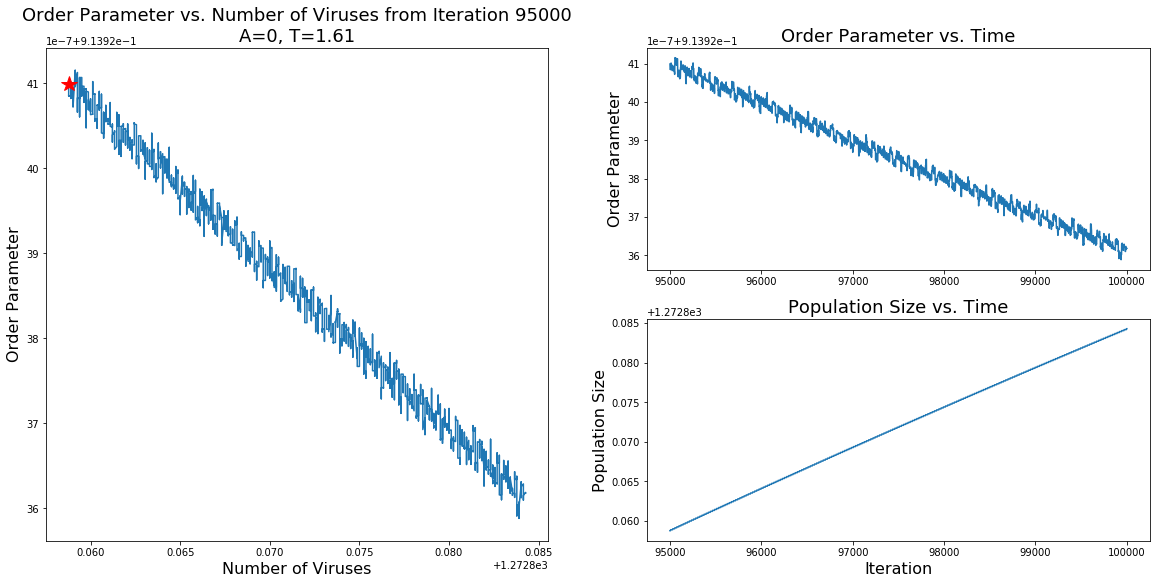

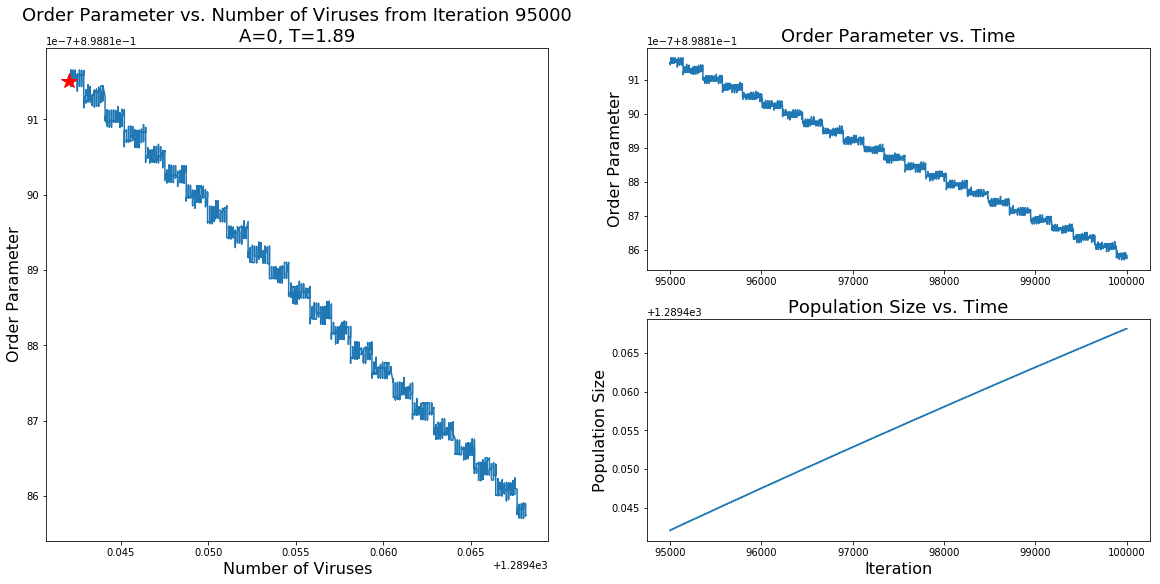

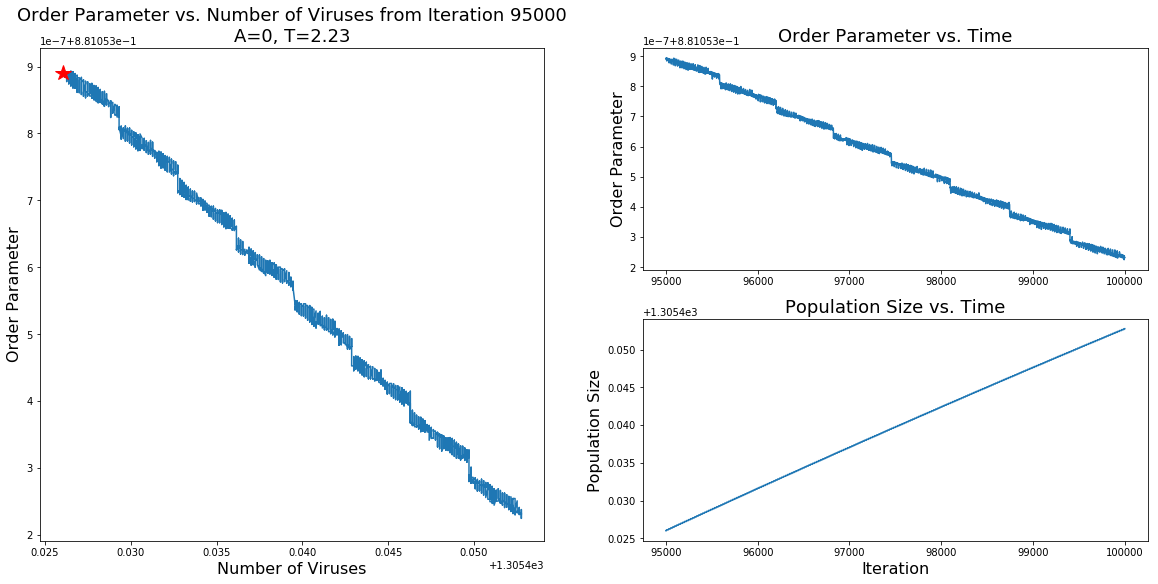

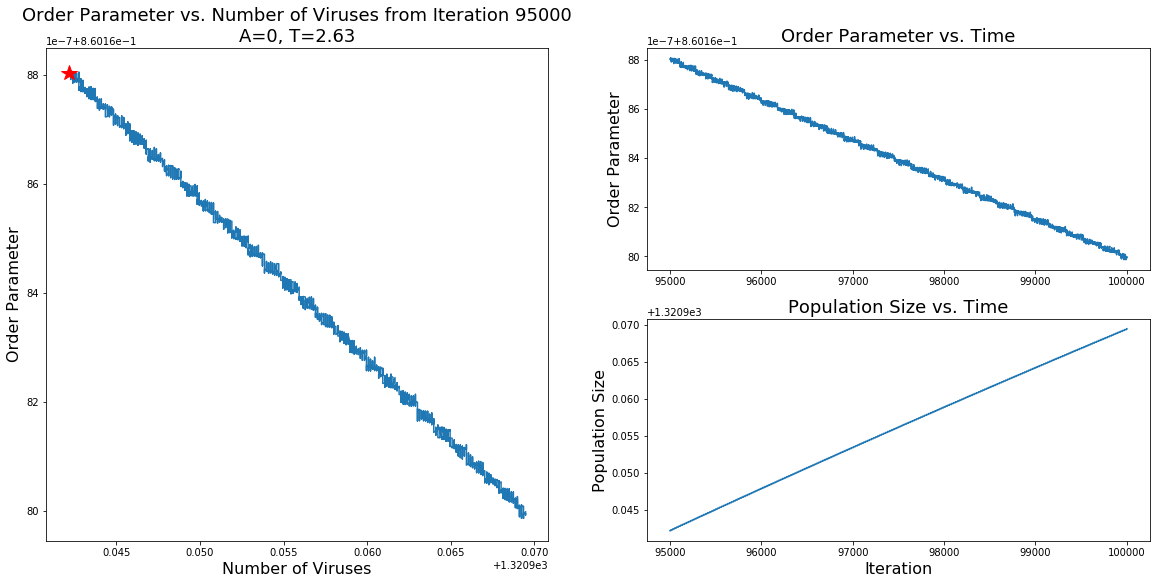

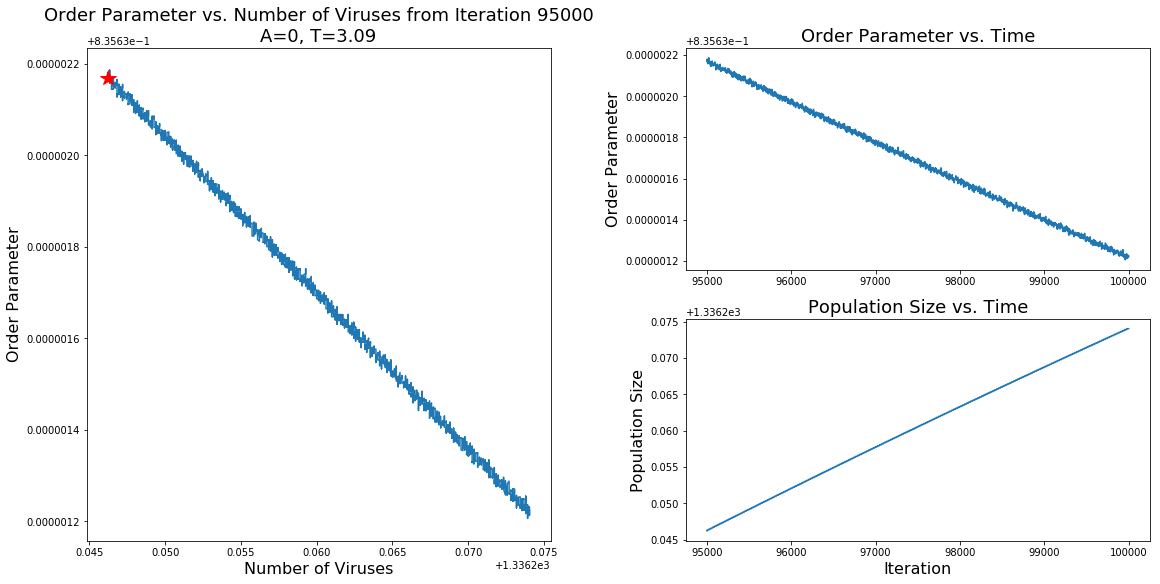

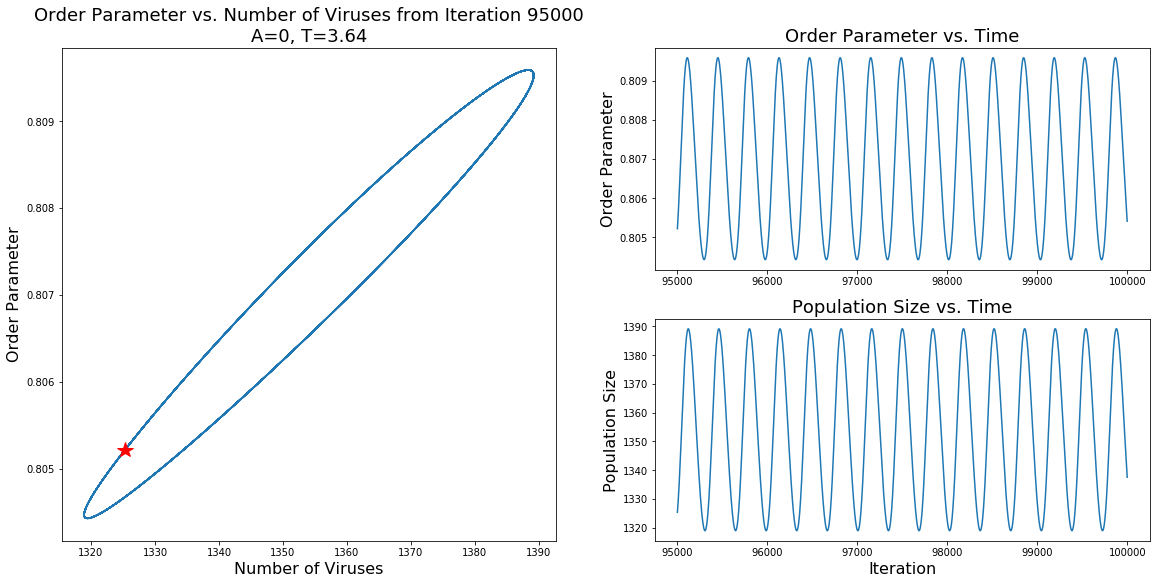

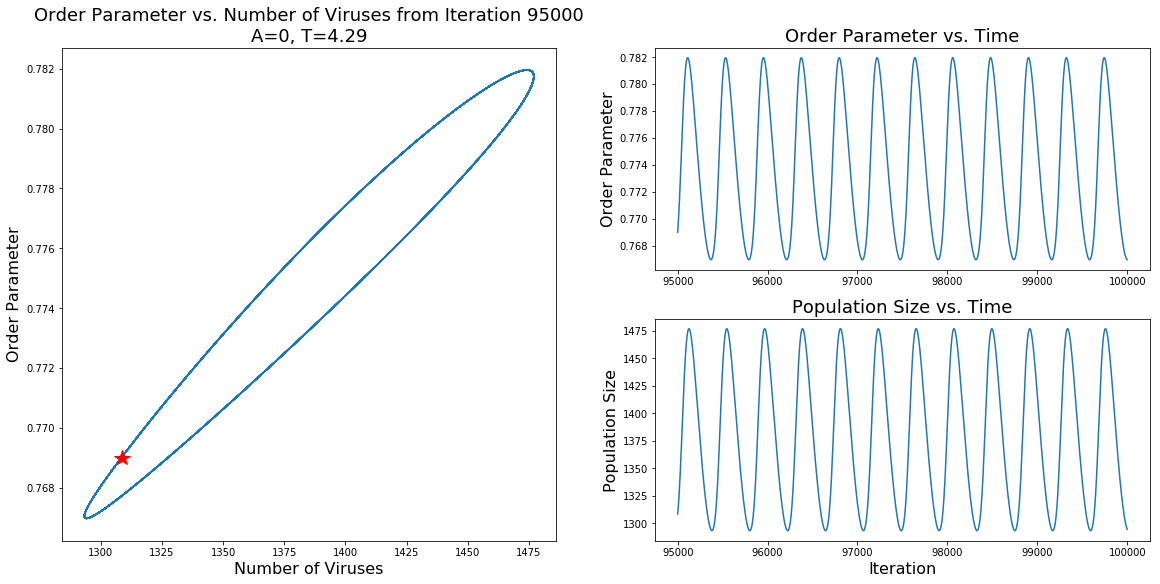

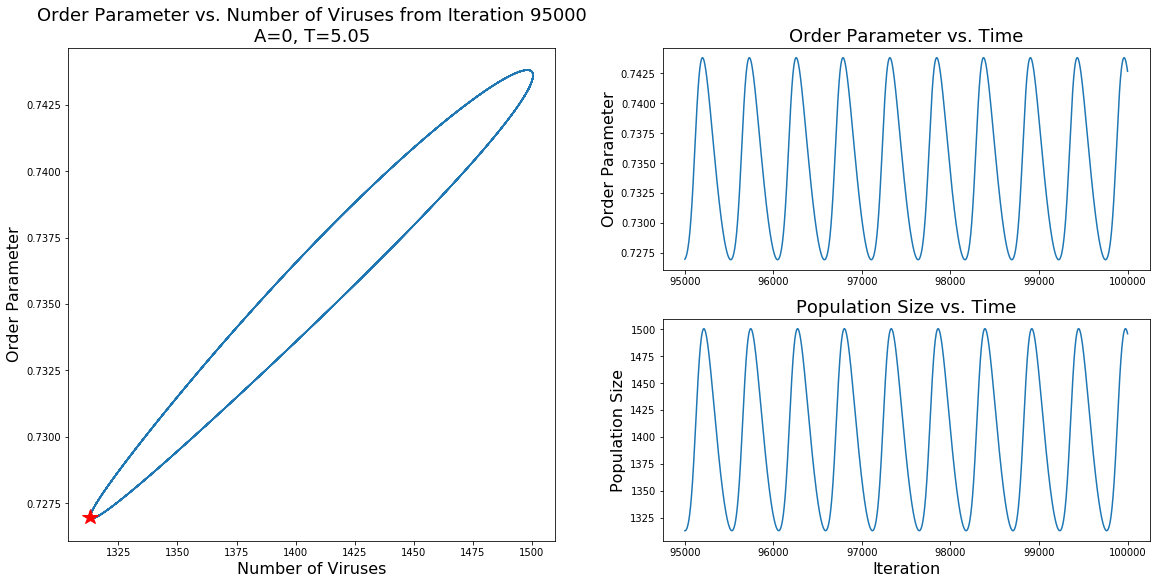

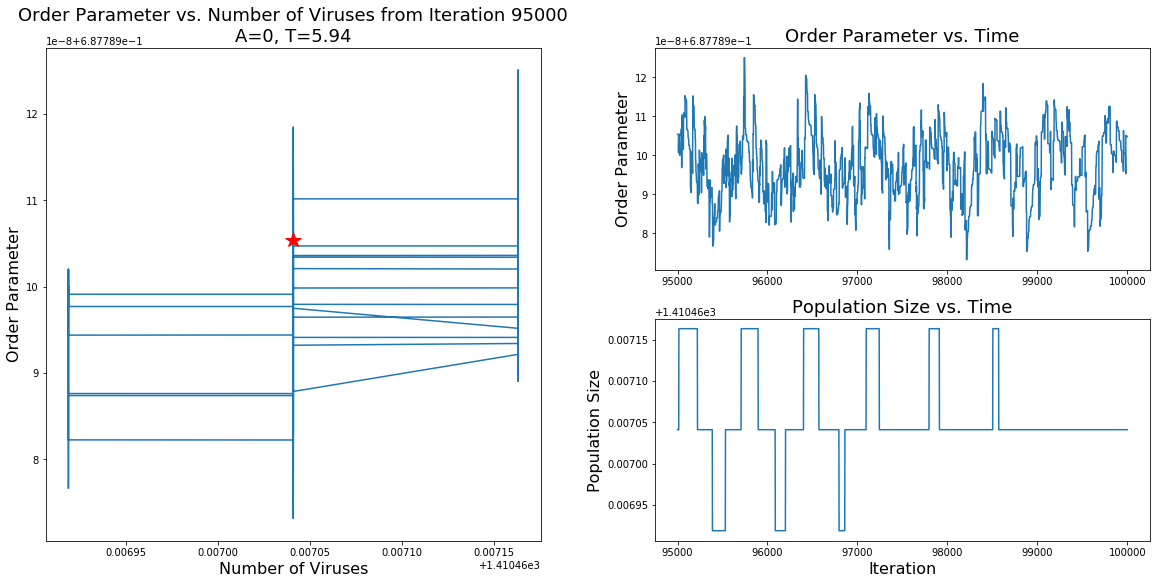

In [50]:
import matplotlib.gridspec as gridspec
for ind in range(17, 26):
    i, j = ind, 0
    perorb_ordpar = (np.sum(np.arange(51))/50.) * np.average(f['prob_dists'][i,j], 
                                              weights = np.arange(51), axis=1)
    step = 1
    start = 95000
    # print(type(i), type(j), type(step), type(start))
    plt.close()
    fig2 = plt.figure(figsize=(16,8), constrained_layout=True)
    # plt.title('Characteristics of Stable Orbit Behavior,\nA=0, T={:0.2f}'.format(temp_vals[15]), size=18, y=1.02)
    spec2 = gridspec.GridSpec(ncols=6, nrows=2, figure=fig2)
    f2_ax1 = fig2.add_subplot(spec2[:, :3])
    f2_ax1.plot(f['pop_size'][i,j,start:], perorb_ordpar[start:])
    f2_ax1.plot(f['pop_size'][i,j,start], perorb_ordpar[start], 'r*', ms=16)
    f2_ax1.set_title('Order Parameter vs. Number of Viruses from Iteration {}\nA=0, T={:0.2f}'.format(start, temp_vals[i]), size=18)
    f2_ax1.set_xlabel('Number of Viruses', size=16)
    f2_ax1.set_ylabel('Order Parameter', size=16)
    f2_ax2 = fig2.add_subplot(spec2[0, 3:])
    f2_ax2.plot(start+np.arange(0,perorb_ordpar[start:].shape[0], step), perorb_ordpar[start::step])
    f2_ax2.set_title('Order Parameter vs. Time', size=18)
    f2_ax2.set_ylabel('Order Parameter', size=16)
    f2_ax3 = fig2.add_subplot(spec2[1:, 3:])
    f2_ax3.plot(start+np.arange(0,f['pop_size'][i,j,start:].shape[0], step), f['pop_size'][i,j,start::step])
    f2_ax3.set_title('Population Size vs. Time', size=18)
    f2_ax3.set_xlabel('Iteration', size=16)
    f2_ax3.set_ylabel('Population Size', size=16)
    # plt.savefig(fl0 + 'StableOrbit' + fl1)
    plt.show()
    plt.close()

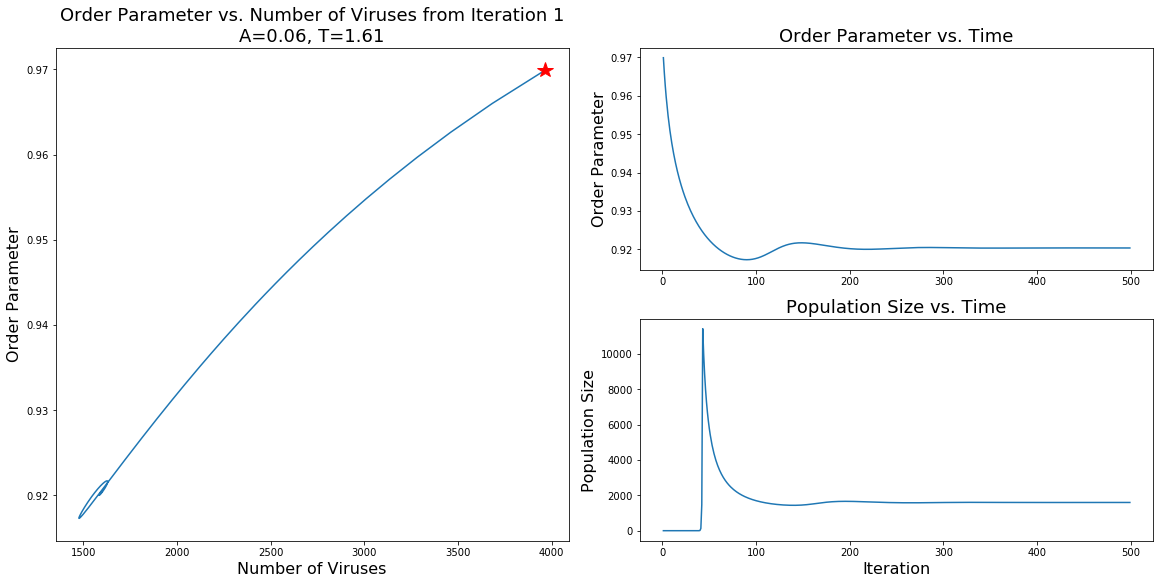

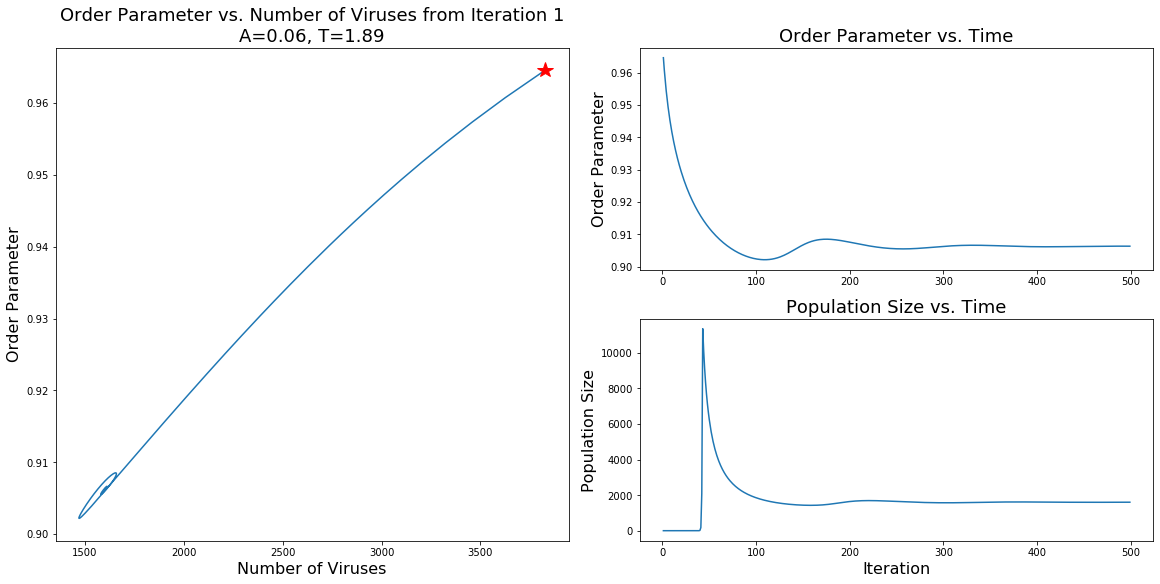

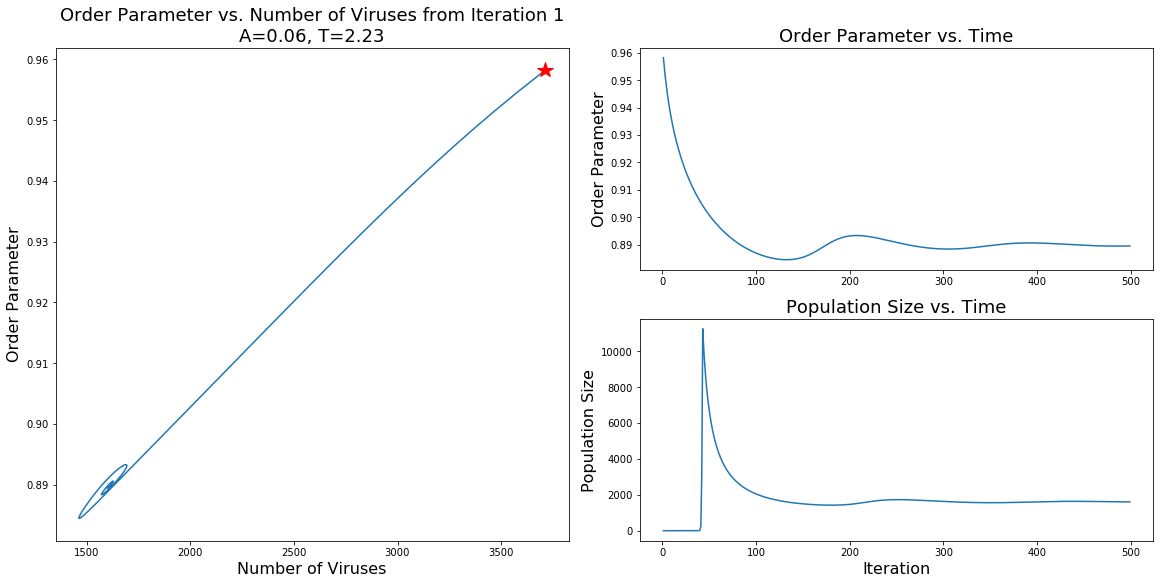

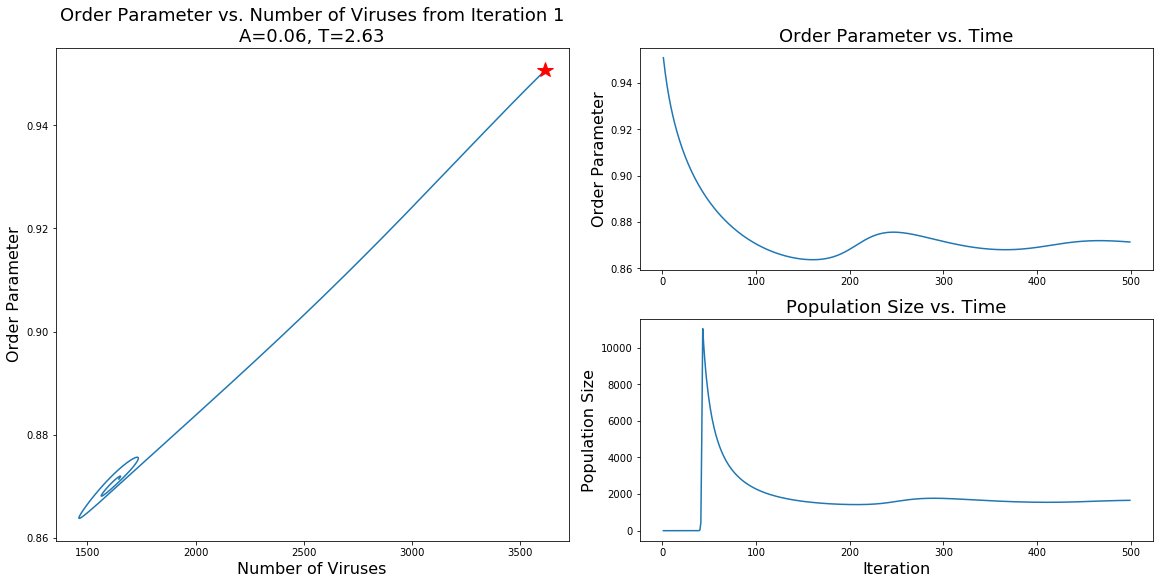

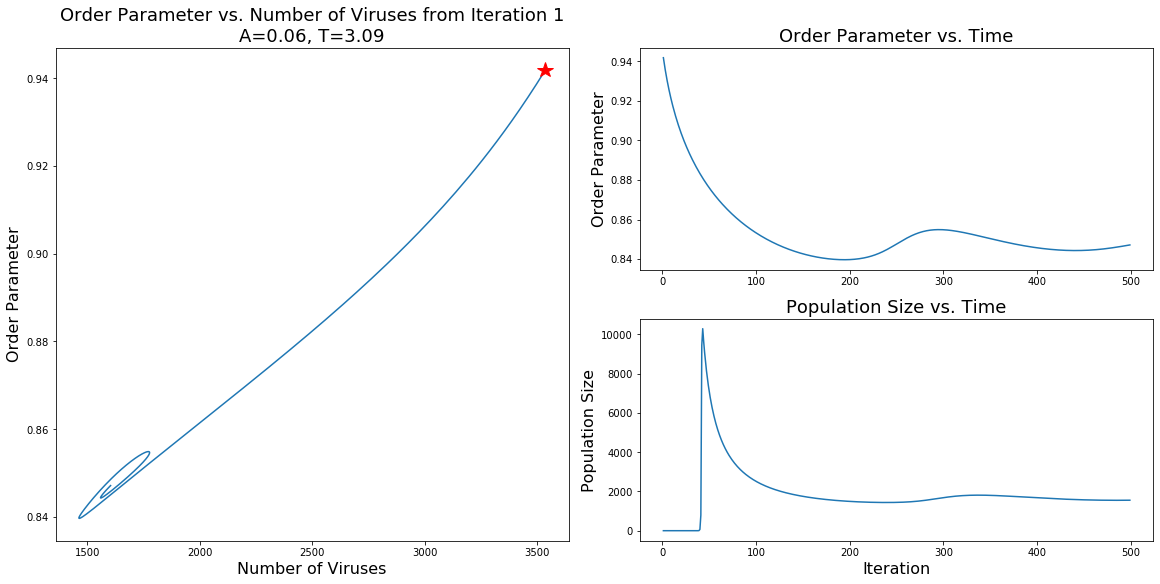

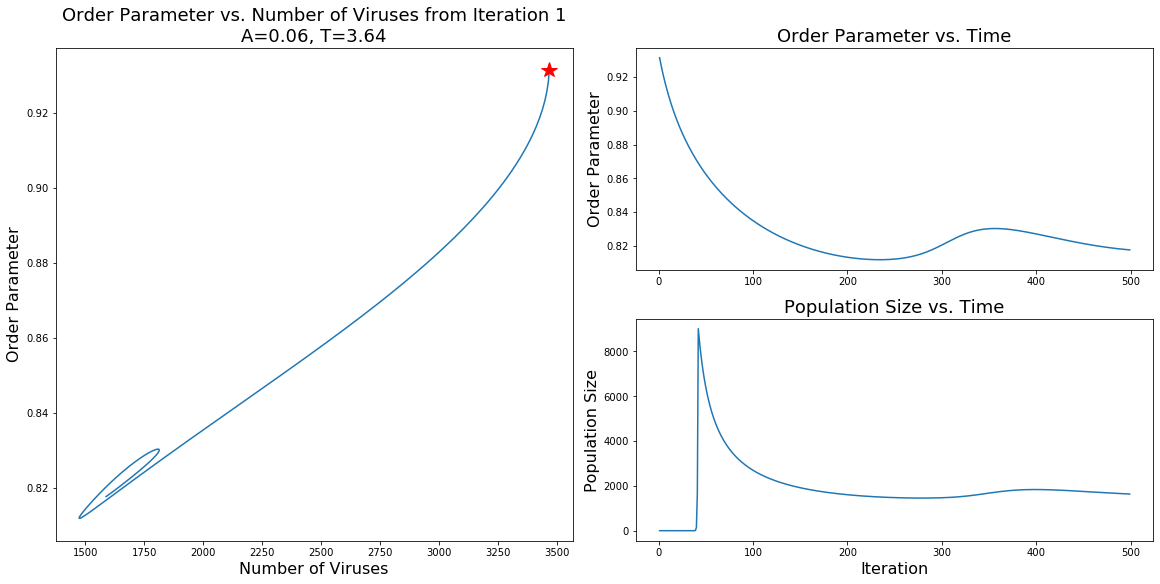

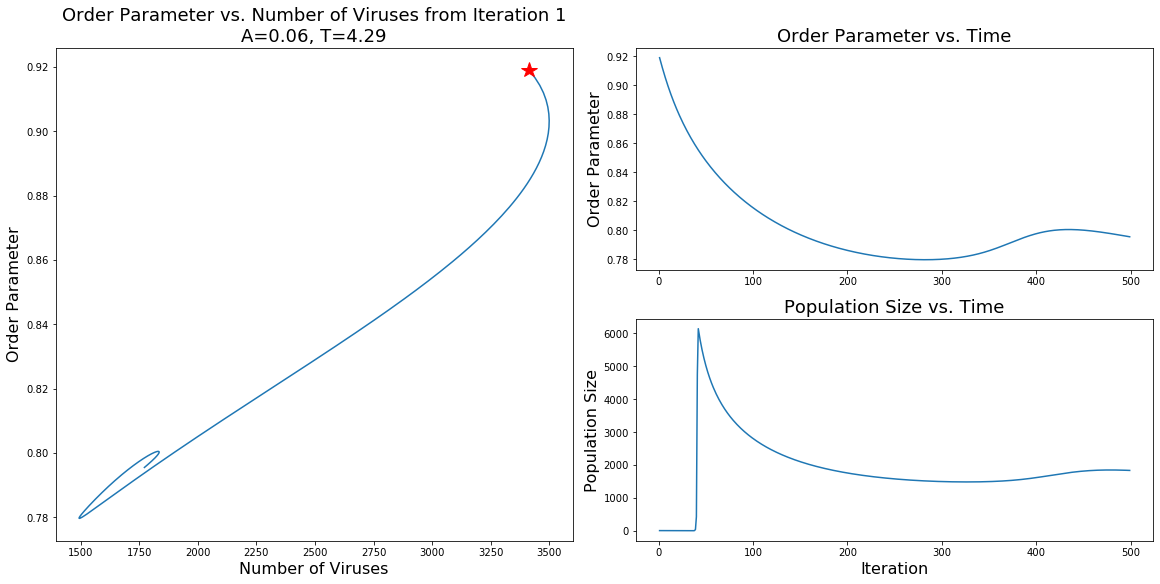

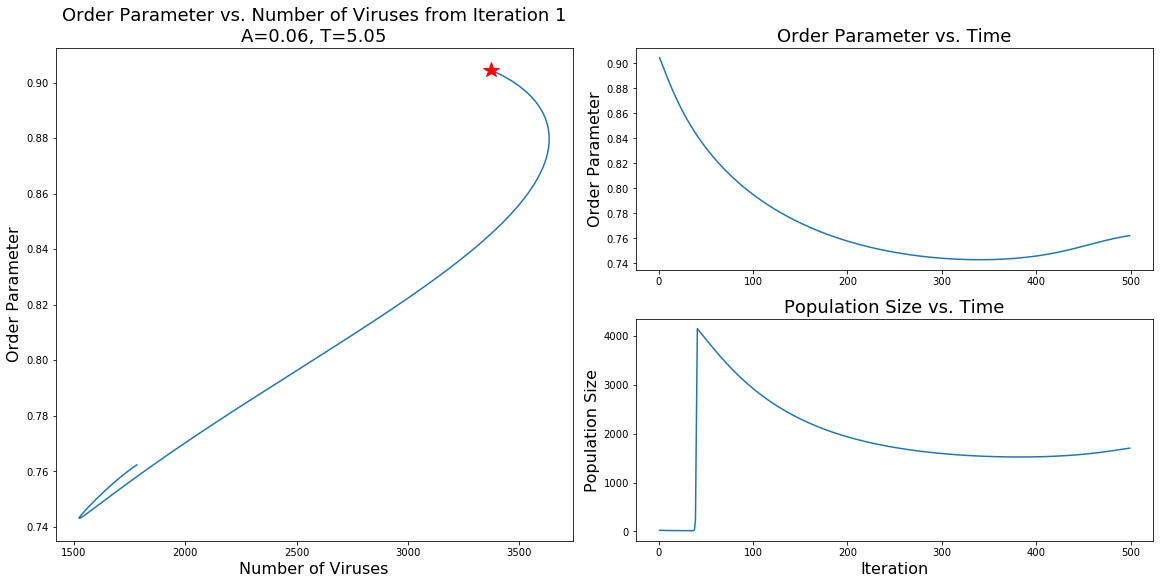

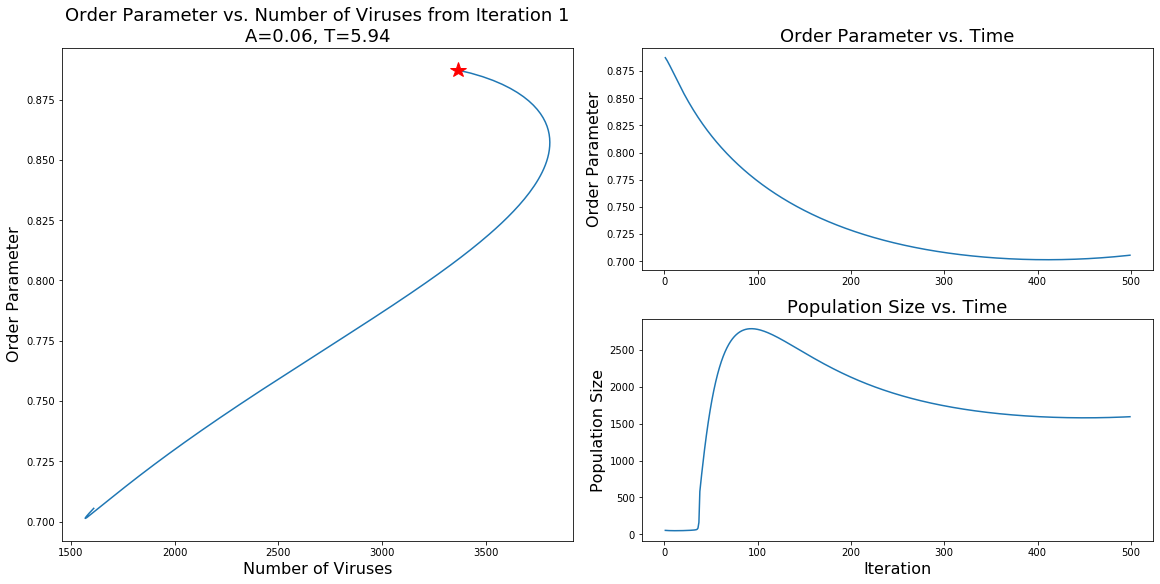

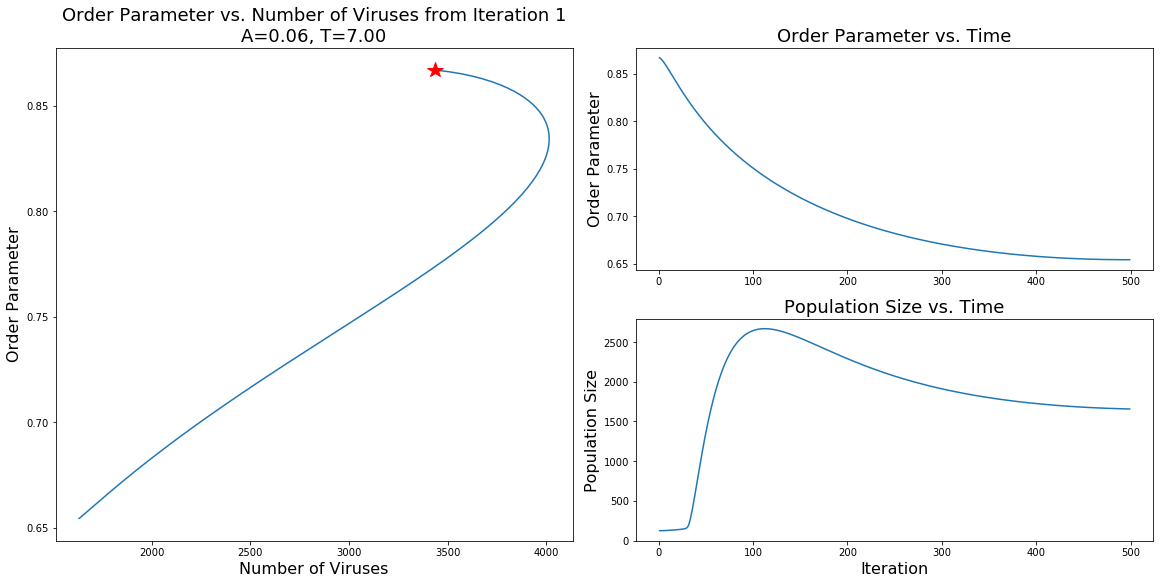

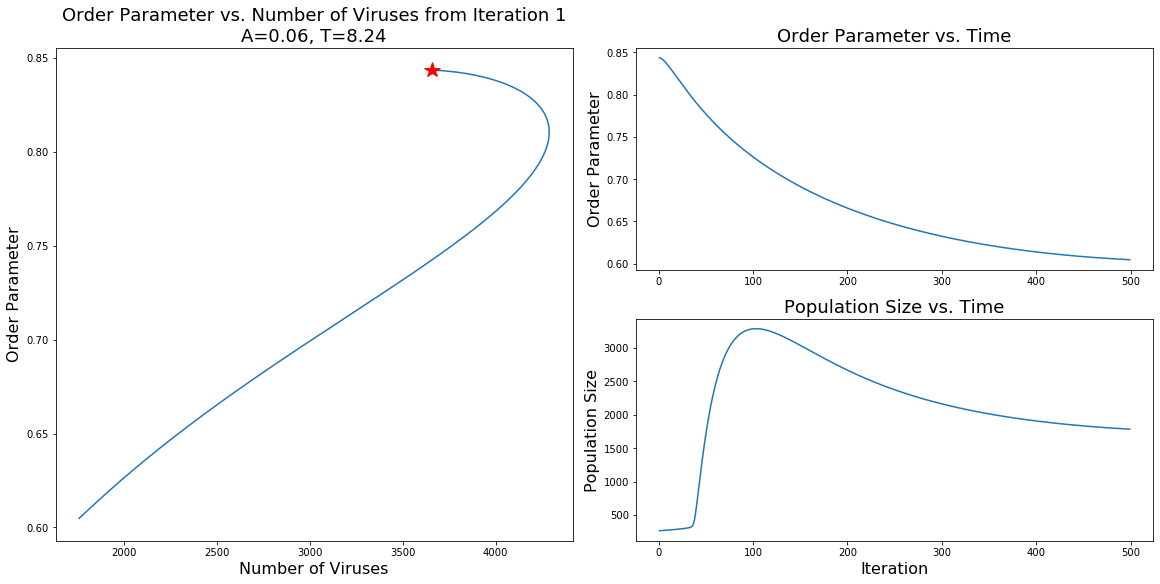

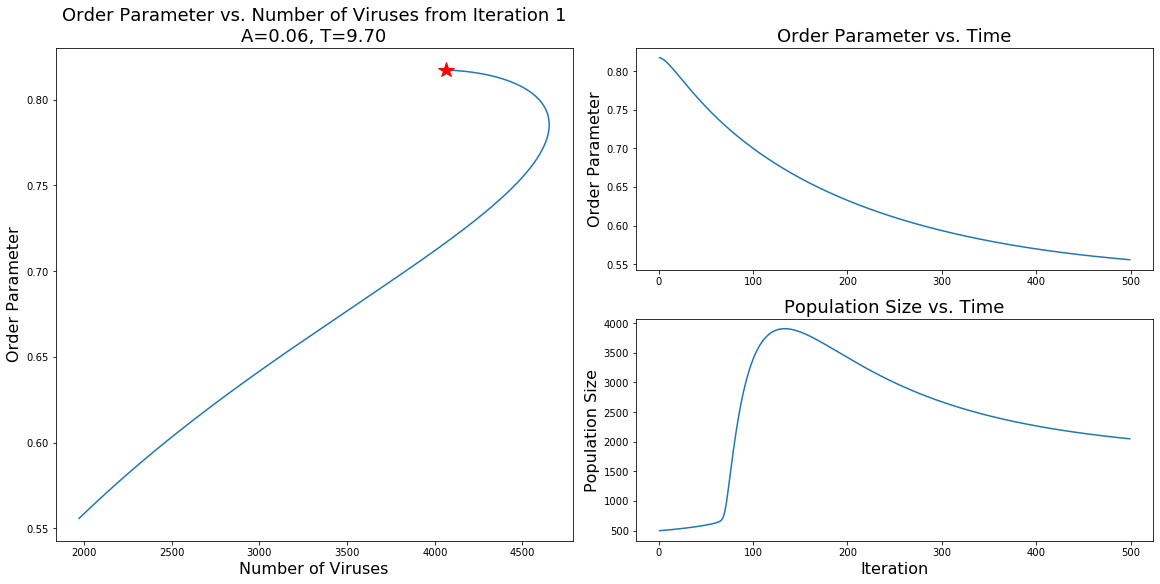

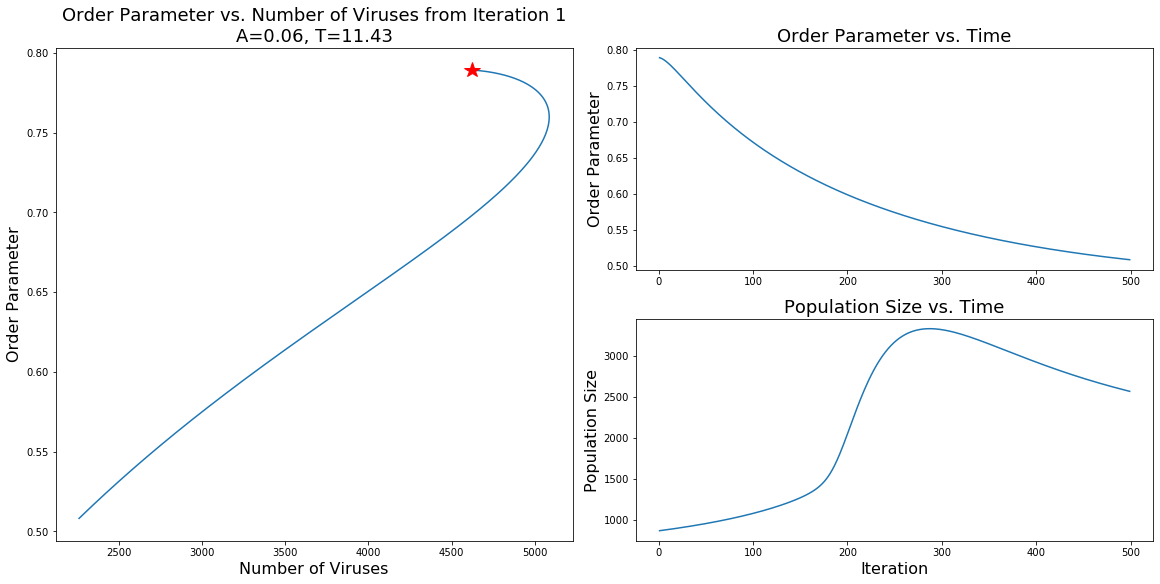

In [30]:
import matplotlib.gridspec as gridspec
for ind in range(17, 30):
    i, j = ind, 1
    perorb_ordpar_nat = (np.sum(np.arange(51))/50.) * np.average(f['prob_dists'][i,j], 
                                              weights = np.arange(51), axis=1)
    step = 1
    start = 10
    end = 5000
    # print(type(i), type(j), type(step), type(start))
    plt.close()
    fig2 = plt.figure(figsize=(16,8), constrained_layout=True)
    # plt.title('Characteristics of Stable Orbit Behavior,\nA=0, T={:0.2f}'.format(temp_vals[15]), size=18, y=1.02)
    spec2 = gridspec.GridSpec(ncols=6, nrows=2, figure=fig2)
    f2_ax1 = fig2.add_subplot(spec2[:, :3])
    f2_ax1.plot(f['pop_size'][i,j,start:end:step], perorb_ordpar_nat[start:end:step])
    f2_ax1.plot(f['pop_size'][i,j,start], perorb_ordpar_nat[start], 'r*', ms=16)
    f2_ax1.set_title('Order Parameter vs. Number of Viruses from Iteration {}\nA=0.02, T={:0.2f}'.format(start, temp_vals[i]), size=18)
    f2_ax1.set_xlabel('Number of Viruses', size=16)
    f2_ax1.set_ylabel('Order Parameter', size=16)
    f2_ax2 = fig2.add_subplot(spec2[0, 3:])
    f2_ax2.plot(np.arange(start, end, step), perorb_ordpar_nat[start:end:step])
    f2_ax2.set_title('Order Parameter vs. Time', size=18)
    f2_ax2.set_ylabel('Order Parameter', size=16)
    f2_ax3 = fig2.add_subplot(spec2[1:, 3:])
    f2_ax3.plot(np.arange(start, end, step), f_nat['pop_size'][i,j,start:end:step])
    f2_ax3.set_title('Population Size vs. Time', size=18)
    f2_ax3.set_xlabel('Iteration', size=16)
    f2_ax3.set_ylabel('Population Size', size=16)
    # plt.savefig(fl0 + 'StableOrbit' + fl1)
    plt.show()
    plt.close()

In [ ]:
import matplotlib.gridspec as gridspec
for ind in range(17, 26):
    i, j = ind, 0
    perorb_ordpar_nat = (np.sum(np.arange(51))/50.) * np.average(f_nat['prob_dists'][i,j], 
                                              weights = np.arange(51), axis=1)
    step = 1
    start = 95000
    # print(type(i), type(j), type(step), type(start))
    plt.close()
    fig2 = plt.figure(figsize=(16,8), constrained_layout=True)
    # plt.title('Characteristics of Stable Orbit Behavior,\nA=0, T={:0.2f}'.format(temp_vals[15]), size=18, y=1.02)
    spec2 = gridspec.GridSpec(ncols=6, nrows=2, figure=fig2)
    f2_ax1 = fig2.add_subplot(spec2[:, :3])
    f2_ax1.plot(f_nat['pop_size'][i,j,start:], perorb_ordpar_nat[start:])
    f2_ax1.plot(f_nat['pop_size'][i,j,start], perorb_ordpar_nat[start], 'r*', ms=16)
    f2_ax1.set_title('Order Parameter vs. Number of Viruses from Iteration {}\nA=0, T={:0.2f}'.format(start, temp_vals[i]), size=18)
    f2_ax1.set_xlabel('Number of Viruses', size=16)
    f2_ax1.set_ylabel('Order Parameter', size=16)
    f2_ax2 = fig2.add_subplot(spec2[0, 3:])
    f2_ax2.plot(start+np.arange(0,perorb_ordpar_nat[start:].shape[0], step), perorb_ordpar_nat[start::step])
    f2_ax2.set_title('Order Parameter vs. Time', size=18)
    f2_ax2.set_ylabel('Order Parameter', size=16)
    f2_ax3 = fig2.add_subplot(spec2[1:, 3:])
    f2_ax3.plot(start+np.arange(0,f_nat['pop_size'][i,j,start:].shape[0], step), f_nat['pop_size'][i,j,start::step])
    f2_ax3.set_title('Population Size vs. Time', size=18)
    f2_ax3.set_xlabel('Iteration', size=16)
    f2_ax3.set_ylabel('Population Size', size=16)
    # plt.savefig(fl0 + 'StableOrbit' + fl1)
    plt.show()
    plt.close()

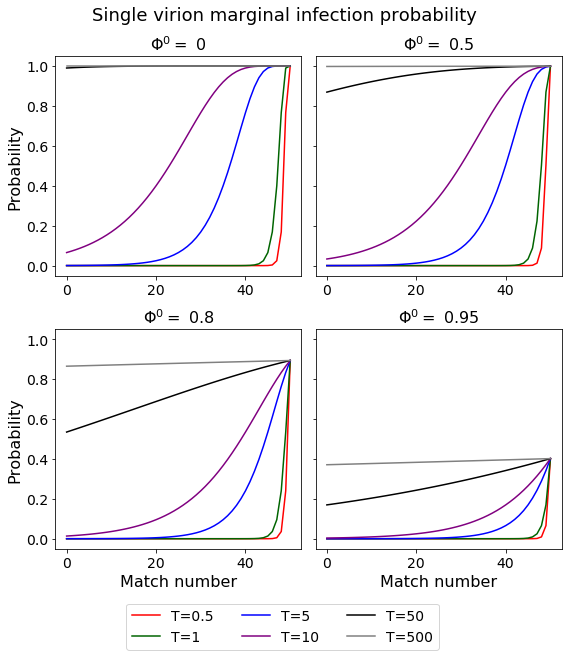

In [7]:
pr_ff = [0, 0.5, 0.8, 0.95]
c_list = ['red', 'darkgreen', 'blue', 'purple', 'black', 'gray']
plt.close()
fig, axs = plt.subplots(2,2, sharey=True, figsize=(8,8))
for i in range(len(pr_ff)):
    for t_to_plot in zip([0.5, 1, 5, 10, 50, 500], c_list):
        axs[int(i/2)][i % 2].plot(range(51), [(1 - np.power(1 - np.exp(-(50-_) / t_to_plot[0]) * 
                                                             (1 - pr_ff[i]), 10)) 
                  for _ in range(51)], c=t_to_plot[1], label='T={}'.format(t_to_plot[0]))
    axs[int(i/2)][i % 2].set_title(r'$\Phi^{0} = $' + ' {}'.format(pr_ff[i]), size=16)
    if i % 2 == 0:
        axs[int(i/2)][i % 2].set_ylabel('Probability', size=16)
    if i > 1:
        axs[int(i/2)][i % 2].set_xlabel('Match number', size=16)
    axs[int(i/2)][i % 2].tick_params(axis='both', labelsize=14)
        
plt.tight_layout()
plt.suptitle('Single virion marginal infection probability', y=1.03, size=18)
plt.legend(bbox_to_anchor=(0.5, -0.25), ncol=3, borderaxespad=0, fontsize=14)
plt.show()
plt.close()

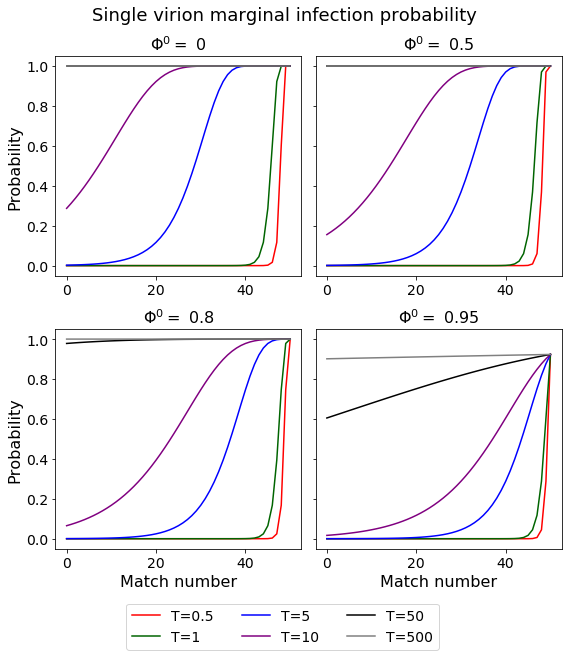

In [4]:
pr_ff = [0, 0.5, 0.8, 0.95]
c_list = ['red', 'darkgreen', 'blue', 'purple', 'black', 'gray']
plt.close()
fig, axs = plt.subplots(2,2, sharey=True, figsize=(8,8))
for i in range(len(pr_ff)):
    for t_to_plot in zip([0.5, 1, 5, 10, 50, 500], c_list):
        axs[int(i/2)][i % 2].plot(range(51), [(1 - np.power(1 - np.exp(-(50-_) / t_to_plot[0]) * 
                                                             (1 - pr_ff[i]), 50)) 
                  for _ in range(51)], c=t_to_plot[1], label='T={}'.format(t_to_plot[0]))
    axs[int(i/2)][i % 2].set_title(r'$\Phi^{0} = $' + ' {}'.format(pr_ff[i]), size=16)
    if i % 2 == 0:
        axs[int(i/2)][i % 2].set_ylabel('Probability', size=16)
    if i > 1:
        axs[int(i/2)][i % 2].set_xlabel('Match number', size=16)
    axs[int(i/2)][i % 2].tick_params(axis='both', labelsize=14)
        
plt.tight_layout()
plt.suptitle('Single virion marginal infection probability', y=1.03, size=18)
plt.legend(bbox_to_anchor=(0.5, -0.25), ncol=3, borderaxespad=0, fontsize=14)
plt.show()
plt.close()

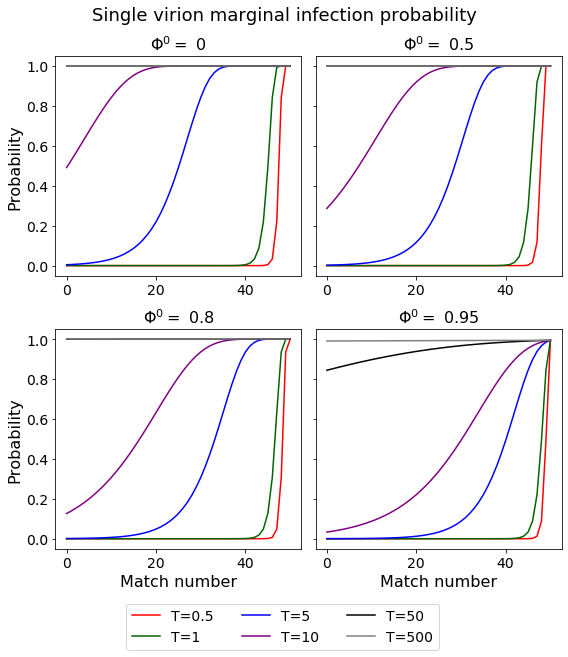

In [6]:
pr_ff = [0, 0.5, 0.8, 0.95]
c_list = ['red', 'darkgreen', 'blue', 'purple', 'black', 'gray']
plt.close()
fig, axs = plt.subplots(2,2, sharey=True, figsize=(8,8))
for i in range(len(pr_ff)):
    for t_to_plot in zip([0.5, 1, 5, 10, 50, 500], c_list):
        axs[int(i/2)][i % 2].plot(range(51), [(1 - np.power(1 - np.exp(-(50-_) / t_to_plot[0]) * 
                                                             (1 - pr_ff[i]), 100)) 
                  for _ in range(51)], c=t_to_plot[1], label='T={}'.format(t_to_plot[0]))
    axs[int(i/2)][i % 2].set_title(r'$\Phi^{0} = $' + ' {}'.format(pr_ff[i]), size=16)
    if i % 2 == 0:
        axs[int(i/2)][i % 2].set_ylabel('Probability', size=16)
    if i > 1:
        axs[int(i/2)][i % 2].set_xlabel('Match number', size=16)
    axs[int(i/2)][i % 2].tick_params(axis='both', labelsize=14)
        
plt.tight_layout()
plt.suptitle('Single virion marginal infection probability', y=1.03, size=18)
plt.legend(bbox_to_anchor=(0.5, -0.25), ncol=3, borderaxespad=0, fontsize=14)
plt.show()
plt.close()

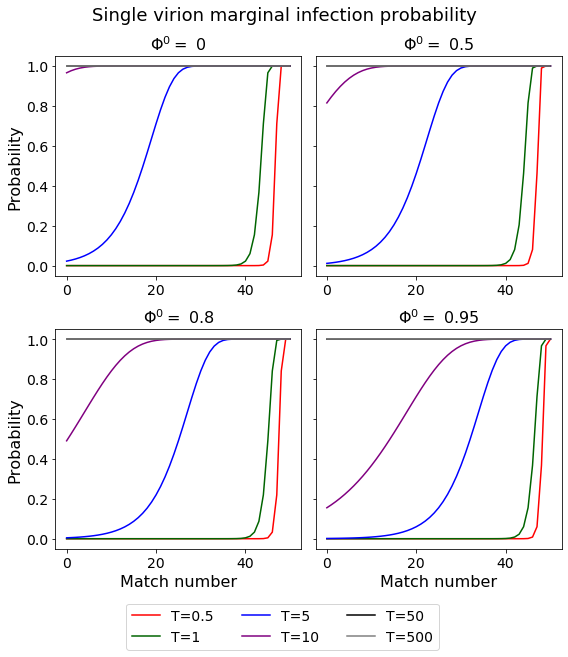

In [5]:
pr_ff = [0, 0.5, 0.8, 0.95]
c_list = ['red', 'darkgreen', 'blue', 'purple', 'black', 'gray']
plt.close()
fig, axs = plt.subplots(2,2, sharey=True, figsize=(8,8))
for i in range(len(pr_ff)):
    for t_to_plot in zip([0.5, 1, 5, 10, 50, 500], c_list):
        axs[int(i/2)][i % 2].plot(range(51), [(1 - np.power(1 - np.exp(-(50-_) / t_to_plot[0]) * 
                                                             (1 - pr_ff[i]), 500)) 
                  for _ in range(51)], c=t_to_plot[1], label='T={}'.format(t_to_plot[0]))
    axs[int(i/2)][i % 2].set_title(r'$\Phi^{0} = $' + ' {}'.format(pr_ff[i]), size=16)
    if i % 2 == 0:
        axs[int(i/2)][i % 2].set_ylabel('Probability', size=16)
    if i > 1:
        axs[int(i/2)][i % 2].set_xlabel('Match number', size=16)
    axs[int(i/2)][i % 2].tick_params(axis='both', labelsize=14)
        
plt.tight_layout()
plt.suptitle('Single virion marginal infection probability', y=1.03, size=18)
plt.legend(bbox_to_anchor=(0.5, -0.25), ncol=3, borderaxespad=0, fontsize=14)
plt.show()
plt.close()

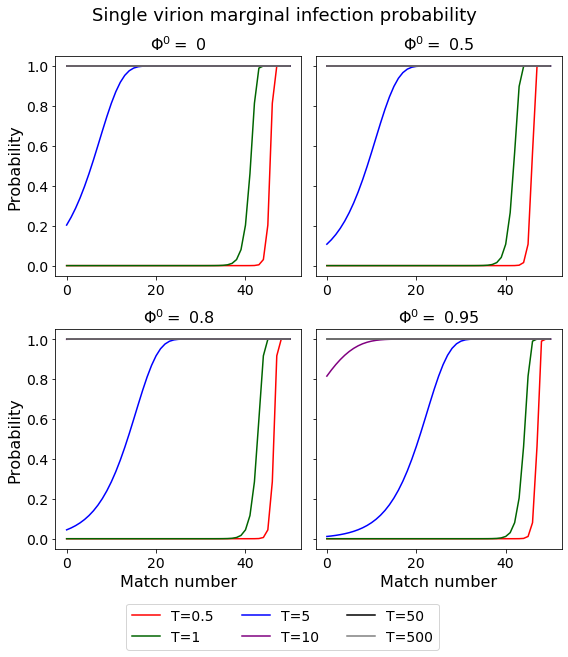

In [7]:
pr_ff = [0, 0.5, 0.8, 0.95]
c_list = ['red', 'darkgreen', 'blue', 'purple', 'black', 'gray']
plt.close()
fig, axs = plt.subplots(2,2, sharey=True, figsize=(8,8))
for i in range(len(pr_ff)):
    for t_to_plot in zip([0.5, 1, 5, 10, 50, 500], c_list):
        axs[int(i/2)][i % 2].plot(range(51), [(1 - np.power(1 - np.exp(-(50-_) / t_to_plot[0]) * 
                                                             (1 - pr_ff[i]), 5000)) 
                  for _ in range(51)], c=t_to_plot[1], label='T={}'.format(t_to_plot[0]))
    axs[int(i/2)][i % 2].set_title(r'$\Phi^{0} = $' + ' {}'.format(pr_ff[i]), size=16)
    if i % 2 == 0:
        axs[int(i/2)][i % 2].set_ylabel('Probability', size=16)
    if i > 1:
        axs[int(i/2)][i % 2].set_xlabel('Match number', size=16)
    axs[int(i/2)][i % 2].tick_params(axis='both', labelsize=14)
        
plt.tight_layout()
plt.suptitle('Single virion marginal infection probability', y=1.03, size=18)
plt.legend(bbox_to_anchor=(0.5, -0.25), ncol=3, borderaxespad=0, fontsize=14)
plt.show()
plt.close()